In [1]:
# Core Python & Utilities
import random
import re
from collections import defaultdict
from itertools import product
from tqdm import tqdm

# Data Handling
import numpy as np
import pandas as pd

# Stats & Modeling
import math
from scipy.optimize import curve_fit
from scipy.stats import sem, t, ttest_ind
from sklearn.cluster import KMeans
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Data Viz
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns

# Preferences
pd.set_option("display.max_columns", None)

# Basic Demo of How it Works

In [2]:
# ------------------------------------------------------------------------------------
# MPR Equation 1: Arousal
# A_t = a * r   (original form)
# Recursive update (running average over time):
# A_t = α * r_t + (1 - α) * A_{t-1}
# where:
#   A_t is arousal at time t
#   a is specific activation (strength of reinforcer)
#   r_t is rate of reinforcement at time t (either 0 or 1)
#   α is the learning rate / smoothing factor (0 < α < 1)
# ------------------------------------------------------------------------------------
def update_arousal(prev_arousal: float, reinforcement: int, alpha: float, a: float) -> float:
    """Update arousal based on previous value and new reinforcement event"""
    return alpha * (a * reinforcement) + (1 - alpha) * prev_arousal

# ------------------------------------------------------------------------------------
# MPR Equation 2b: Response Constraint
# b_total = (1 / δ) * (A / (1 + A))
# where:
#   b_total is the total rate of behavior (target + competing responses)
#   δ is the duration of a response
#   A is current arousal
# ------------------------------------------------------------------------------------
def compute_total_response_rate(A: float, delta: float) -> float:
    """Compute total response rate given arousal and motor constraint"""
    return (1 / delta) * (A / (1 + A))

# ------------------------------------------------------------------------------------
# MPR Equation 7: Direction/Coupling
# b_target = C * (1 / δ) * (A / (1 + A))
# where:
#   b_target is the rate of the target response (e.g., lever press)
#   C is the coupling coefficient, representing directional control (0 to 1)
# ------------------------------------------------------------------------------------
def compute_target_response_rate(A: float, delta: float, coupling: float) -> float:
    """Compute target response rate based on arousal and coupling"""
    return coupling * (1 / delta) * (A / (1 + A))


# ------------------------------------------------------------------------------------
# Coupling update (based on schedule-sensitive asymptote):
# 
# C_t = C_{t-1} + η * (C* - C_{t-1})
#
# Where:
#   - η         : coupling learning rate (0 < η < 1)
#   - C*        : asymptotic coupling value based on schedule type and parameters
#
# C* is computed differently depending on the reinforcement schedule:
#   - FR:    C* = 1 - exp(-λ * n)                     (n = fixed ratio value)
#   - VR:    C* = 1 - exp(-λ * E[n])                  (E[n] = expected ratio)
#   - FI:    C* = ρ * (r / (r + k))                   (r = reinforcement rate)
#   - VI:    C* = ρ * (r / (r + k)) * ε               (ε < 1 dampens coupling)
#
# This reflects the idea that coupling depends not only on reinforcement occurrence,
# but on the organism's ability to detect contingency in the schedule structure.
# ------------------------------------------------------------------------------------
def compute_c_star(schedule_type: str,schedule_param: float, reinforcement_rate: float, lambda_: float = 0.3,
                   rho: float = 0.6, k: float = 1.0,epsilon: float = 0.8) -> float:
    """
    Compute schedule-sensitive asymptotic coupling value (C*) based on schedule type.
    """
    if schedule_type == 'FR':
        # schedule_param is the fixed ratio value (e.g., 10)
        return 1 - math.exp(-lambda_ * schedule_param)
    elif schedule_type == 'VR':
        # schedule_param is expected ratio (mean of the distribution)
        return 1 - math.exp(-lambda_ * schedule_param)
    elif schedule_type == 'FI':
        # reinforcement_rate: reinforcers per unit time
        return rho * (reinforcement_rate / (reinforcement_rate + k))
    elif schedule_type == 'VI':
        return rho * (reinforcement_rate / (reinforcement_rate + k)) * epsilon
    else:
        # Default case (uncoupled or unspecified schedule)
        return 0.0

def update_coupling(prev_coupling: float, c_star: float, learning_rate: float = 0.05) -> float:
    """
    Update coupling coefficient based on schedule-sensitive asymptote.
    """
    return prev_coupling + learning_rate * (c_star - prev_coupling)

# def update_coupling(prev_coupling: float, was_reinforced: bool, learning_rate: float = 0.05, proximity: float = 1.0) -> float:
#     """Update coupling coefficient based on reinforcement outcome"""
#     target = proximity if was_reinforced else 0.1
#     return prev_coupling + learning_rate * (target - prev_coupling)


# ------------------------------------------------------------------------------------
# Wrapper for a single update step in the MPR simulation.
#
# This function updates:
#   - Arousal (A), based on recent reinforcement and learning rate α
#   - Coupling (C), using a recursive update toward a schedule-sensitive asymptote C*
#   - Total response rate (b_total), based on motor constraint and arousal
#   - Target response rate (b_target), incorporating both arousal and coupling
#
# Inputs:
#   prev_arousal         : float    - Arousal level at previous time step
#   prev_coupling        : float    - Coupling strength at previous time step
#   reinforcement        : int      - Reinforcement received at current step (0 or 1)
#   a                    : float    - Specific activation (reinforcer magnitude)
#   delta                : float    - Duration of a response (motor constraint)
#   alpha                : float    - Learning rate for arousal (default: 0.1)
#   eta                  : float    - Learning rate for coupling (default: 0.05)
#   schedule_type        : str      - One of 'FR', 'VR', 'FI', 'VI'
#   schedule_param       : float    - Schedule parameter (e.g., FR value, VI mean)
#   reinforcement_rate   : float    - Moving average of reinforcement per unit time
#   lambda_              : float    - Steepness of coupling growth (FR/VR)
#   rho                  : float    - Temporal coupling strength (FI/VI)
#   k                    : float    - Decoupling constant (FI/VI)
#   epsilon              : float    - Dampening factor for VI (uncertainty)
#
# Outputs:
#   A                    : float    - Updated arousal
#   C                    : float    - Updated coupling
#   b_total              : float    - Total response rate
#   b_target             : float    - Target response rate
# ------------------------------------------------------------------------------------
def update_step(prev_arousal, prev_coupling, reinforcement, a, delta, alpha=0.1, eta=0.05,
                schedule_type='VR', schedule_param=10, reinforcement_rate=1.0, lambda_=0.3,
                rho=0.6, k=1.0, epsilon=0.8):
    """
    Run one update of arousal, coupling, and response rates.
    Coupling now updates toward a schedule-sensitive asymptote C*.
    """
    # Update arousal
    A = update_arousal(prev_arousal, reinforcement, alpha, a)

    # Compute coupling asymptote C* based on schedule
    C_star = compute_c_star(
        schedule_type=schedule_type,
        schedule_param=schedule_param,
        reinforcement_rate=reinforcement_rate,
        lambda_=lambda_,
        rho=rho,
        k=k,
        epsilon=epsilon
    )

    # Update coupling toward C*
    C = update_coupling(prev_coupling, c_star=C_star, learning_rate=eta)

    # Compute response rates
    b_total = compute_total_response_rate(A, delta)
    b_target = compute_target_response_rate(A, delta, C)

    return A, C, b_total, b_target

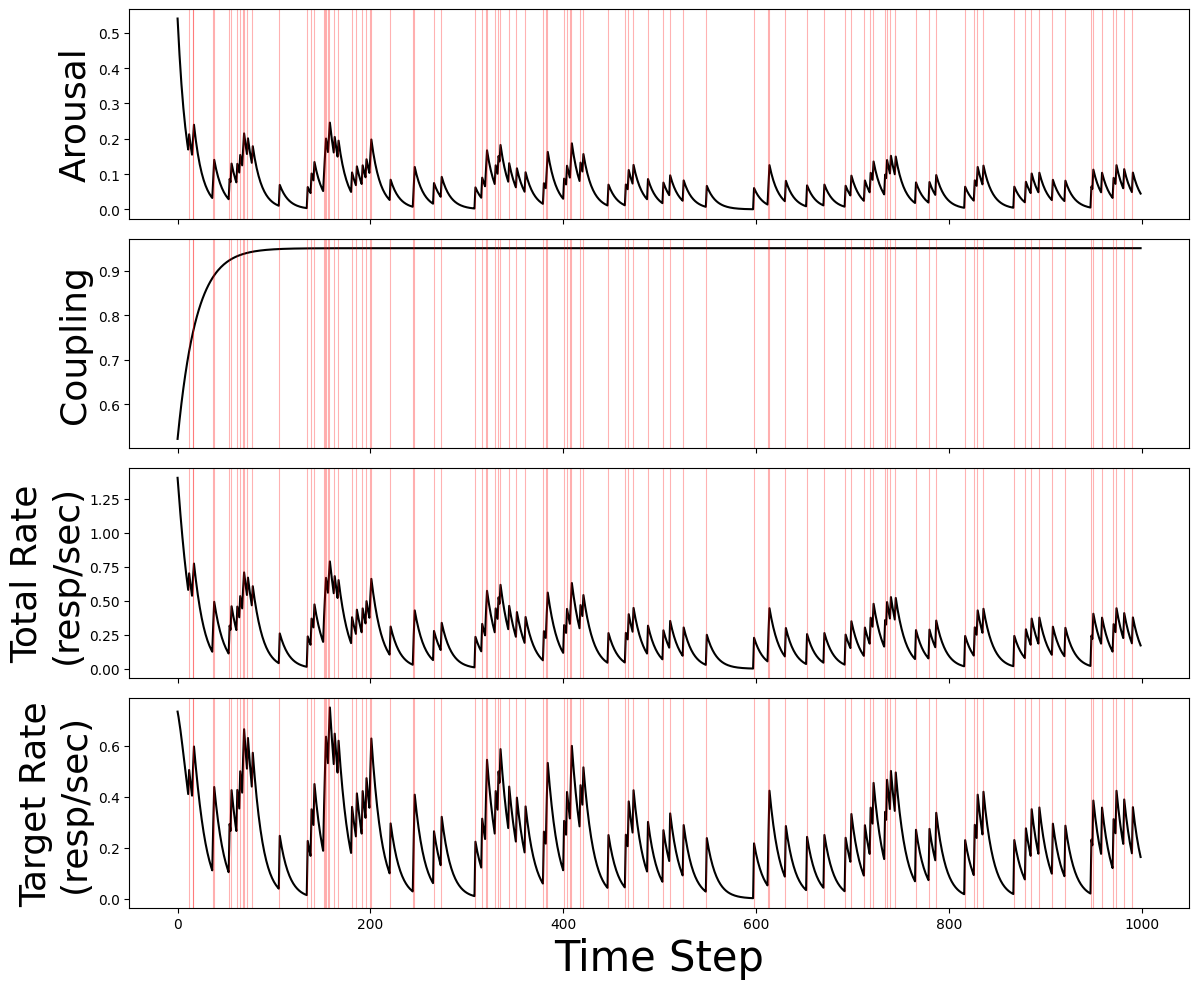

In [3]:
# Parameters
num_steps = 1000
delta = 0.25
a = 0.6
alpha = 0.1
eta = 0.05
schedule_type = 'VR'
schedule_param = 10  # VR-10

# Constants for coupling dynamics
lambda_ = 0.3
rho = 0.6
k = 1.0
epsilon = 0.8
reinforcement_window = 50  # for moving average

# Initialize state
A = 0.6
C = 0.5
arousal_history = []
coupling_history = []
b_total_history = []
b_target_history = []
reinforcement_history = []
reinforced_times = []

# Simulation loop
for time_step in range(num_steps):
    # Simulate reinforcement (VR)
    reinforcement = np.random.rand() < (1 / schedule_param)
    reinforcement_history.append(reinforcement)
    if reinforcement:
        reinforced_times.append(time_step)

    # Compute reinforcement rate (moving average)
    recent = reinforcement_history[-reinforcement_window:]
    reinforcement_rate = sum(recent) / reinforcement_window

    # Update model
    A, C, b_total, b_target = update_step(
        prev_arousal=A,
        prev_coupling=C,
        reinforcement=reinforcement,
        a=a,
        delta=delta,
        alpha=alpha,
        eta=eta,
        schedule_type=schedule_type,
        schedule_param=schedule_param,
        reinforcement_rate=reinforcement_rate,
        lambda_=lambda_,
        rho=rho,
        k=k,
        epsilon=epsilon
    )

    # Record values
    arousal_history.append(A)
    coupling_history.append(C)
    b_total_history.append(b_total)
    b_target_history.append(b_target)

# Plotting
fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

def add_reinforcement_lines(ax):
    for rt in reinforced_times:
        ax.axvline(x=rt - 0.5, color='red', alpha=0.3, linewidth=0.8)

axs[0].plot(arousal_history, color='k', label="Arousal (A)")
add_reinforcement_lines(axs[0])
axs[0].set_ylabel("Arousal", fontsize=26)
# axs[0].legend(fontsize=14)

axs[1].plot(coupling_history, color='k', label="Coupling (C)")
add_reinforcement_lines(axs[1])
axs[1].set_ylabel("Coupling", fontsize=26)
# axs[1].legend(fontsize=14)

axs[2].plot(b_total_history, color='k', label="Total Response Rate")
add_reinforcement_lines(axs[2])
axs[2].set_ylabel("Total Rate\n(resp/sec)", fontsize=26)
# axs[2].legend(fontsize=14)

axs[3].plot(b_target_history, color='k', label="Target Response Rate")
add_reinforcement_lines(axs[3])
axs[3].set_ylabel("Target Rate\n(resp/sec)", fontsize=26)
# axs[3].legend(fontsize=14)
axs[3].set_xlabel("Time Step", fontsize=30)

plt.tight_layout()
plt.show()


# A Range of Single VR Schedule

In [4]:
# --- MPR Model Functions ---
def update_arousal(prev_arousal: float, reinforcement: int, alpha: float, a: float) -> float:
    return alpha * (a * reinforcement) + (1 - alpha) * prev_arousal

def compute_total_response_rate(A: float, delta: float) -> float:
    return (1 / delta) * (A / (1 + A))

def compute_target_response_rate(A: float, delta: float, coupling: float) -> float:
    return coupling * (1 / delta) * (A / (1 + A))

def compute_c_star(schedule_type: str, schedule_param: float, reinforcement_rate: float,
                   lambda_: float = 0.3, rho: float = 0.6, k: float = 1.0, epsilon: float = 0.8) -> float:
    if schedule_type == 'FR':
        return 1 - math.exp(-lambda_ * schedule_param)
    elif schedule_type == 'VR':
        return 1 - math.exp(-lambda_ * schedule_param)
    elif schedule_type == 'FI':
        return rho * (reinforcement_rate / (reinforcement_rate + k))
    elif schedule_type == 'VI':
        return rho * (reinforcement_rate / (reinforcement_rate + k)) * epsilon
    else:
        return 0.0

def update_coupling(prev_coupling: float, c_star: float, learning_rate: float) -> float:
    return prev_coupling + learning_rate * (c_star - prev_coupling)

def update_step(prev_arousal, prev_coupling, reinforcement, a, delta, alpha, eta,
                schedule_type='VR', schedule_param=10, reinforcement_rate=1.0,
                lambda_=0.3, rho=0.6, k=1.0, epsilon=0.8):
    
    A = update_arousal(prev_arousal, reinforcement, alpha, a)

    C_star = compute_c_star(schedule_type, schedule_param, reinforcement_rate,
                            lambda_, rho, k, epsilon)
    
    C = update_coupling(prev_coupling, c_star=C_star, learning_rate=eta)

    b_total = compute_total_response_rate(A, delta)
    b_target = compute_target_response_rate(A, delta, C)

    return A, C, b_total, b_target


# --- Confidence Interval ---
def ci95(data):
    n = len(data)
    return sem(data) * t.ppf(0.975, n - 1)

# --- Main Simulation Function ---
def simulate_mpr_sequence(vr_schedule_list, a, delta, alpha, eta, ao_id, steps_per_schedule=1000,
                          lambda_=0.3, rho=0.6, k=1.0, epsilon=0.8):
    A, C = 0.6, 0.5
    all_results = []

    for vr_idx, vr in enumerate(vr_schedule_list):
        A_hist, C_hist, bt_hist, bp_hist = [], [], [], []
        reinforcement_history = []

        for step in range(steps_per_schedule):
            reinforcement = np.random.rand() < (1 / vr)
            reinforcement_history.append(reinforcement)

            # Use recent reinforcement rate (sliding window of 50 steps)
            window = 50
            recent = reinforcement_history[-window:]
            reinforcement_rate = sum(recent) / window

            # Run update step with schedule-aware coupling
            A, C, b_total, b_target = update_step(
                prev_arousal=A,
                prev_coupling=C,
                reinforcement=reinforcement,
                a=a,
                delta=delta,
                alpha=alpha,
                eta=eta,
                schedule_type='VR',
                schedule_param=vr,
                reinforcement_rate=reinforcement_rate,
                lambda_=lambda_,
                rho=rho,
                k=k,
                epsilon=epsilon
            )

            A_hist.append(A)
            C_hist.append(C)
            bt_hist.append(b_total)
            bp_hist.append(b_target)

        all_results.append({
            'AO_id': ao_id,
            'vr_sequence_index': vr_idx,
            'VR': vr,
            'arousal_avg': np.mean(A_hist),
            'arousal_min': np.min(A_hist),
            'arousal_max': np.max(A_hist),
            'arousal_ci': ci95(A_hist),
            'coupling_avg': np.mean(C_hist),
            'coupling_min': np.min(C_hist),
            'coupling_max': np.max(C_hist),
            'coupling_ci': ci95(C_hist),
            'b_total_avg': np.mean(bt_hist),
            'b_total_min': np.min(bt_hist),
            'b_total_max': np.max(bt_hist),
            'b_total_ci': ci95(bt_hist),
            'b_target_avg': np.mean(bp_hist),
            'b_target_min': np.min(bp_hist),
            'b_target_max': np.max(bp_hist),
            'b_target_ci': ci95(bp_hist),
            'activation': a,
            'delta': delta,
            'alpha': alpha,
            'eta': eta,
        })

    return all_results


# --- Parameter Grid ---
deltas = [0.25, 0.50, 1.0, 2.0]
activations = [0.1, 0.2, 0.4, 0.8, 1.6]
alphas = [0.01, 0.03, 0.1, 0.3, 1.0]
etas = [0.01, 0.03, 0.3, 1.0]
vr_schedules = [1, 3, 10, 30, 100, 300, 1000]

# --- Grid Search Over AO Parameter Combinations ---
results = []
grid = list(product(activations, deltas, alphas, etas))

for ao_id, (a, delta, alpha, eta) in enumerate(tqdm(grid, desc="Running simulations per AO")):
    shuffled_vrs = np.random.permutation(vr_schedules)
    sim_result_list = simulate_mpr_sequence(
        vr_schedule_list=shuffled_vrs,
        a=a,
        delta=delta,
        alpha=alpha,
        eta=eta,
        ao_id=ao_id
    )
    results.extend(sim_result_list)

# --- Final Results DataFrame ---
results_df = pd.DataFrame(results)

# Sample Output
results_df

Running simulations per AO: 100%|██████████| 400/400 [00:50<00:00,  7.93it/s]


,AO_id,vr_sequence_index,VR,arousal_avg,arousal_min,arousal_max,arousal_ci,coupling_avg,coupling_min,coupling_max,coupling_ci,b_total_avg,b_total_min,b_total_max,b_total_ci,b_target_avg,b_target_min,b_target_max,b_target_ci,activation,delta,alpha,eta
0,0,0,10,0.067562,0.007887,0.594000,0.007265,0.905644,0.504502,0.950193,5.551871e-03,0.217258,0.031302,1.490590,0.020451,0.167470,0.029721,0.767740,0.013367,0.1,0.25,0.01,0.01
1,0,1,1000,0.001017,0.000023,0.008383,0.000100,0.995069,0.950692,0.999998,6.141967e-04,0.004054,0.000091,0.033254,0.000398,0.003971,0.000091,0.031614,0.000384,0.1,0.25,0.01,0.01
2,0,2,300,0.000407,0.000001,0.002038,0.000030,1.000000,0.999998,1.000000,2.651564e-08,0.001628,0.000006,0.008137,0.000121,0.001628,0.000006,0.008137,0.000121,0.1,0.25,0.01,0.01
3,0,3,30,0.003006,0.000087,0.005879,0.000082,0.999889,0.999877,0.999999,1.521846e-06,0.011979,0.000346,0.023378,0.000325,0.011978,0.000346,0.023375,0.000325,0.1,0.25,0.01,0.01
4,0,4,1,0.090509,0.005083,0.099996,0.001182,0.332507,0.259214,0.992470,9.133994e-03,0.330815,0.020229,0.363623,0.004167,0.100128,0.020076,0.129289,0.000819,0.1,0.25,0.01,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2795,399,2,3,0.531200,0.000000,1.600000,0.046781,0.593430,0.593430,0.593430,0.000000e+00,0.102154,0.000000,0.307692,0.008996,0.060621,0.000000,0.182594,0.005339,1.6,2.00,1.00,1.00
2796,399,3,1000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.6,2.00,1.00,1.00
2797,399,4,30,0.059200,0.000000,1.600000,0.018751,0.999877,0.999877,0.999877,1.378580e-17,0.011385,0.000000,0.307692,0.003606,0.011383,0.000000,0.307654,0.003606,1.6,2.00,1.00,1.00
2798,399,5,100,0.014400,0.000000,1.600000,0.009381,1.000000,1.000000,1.000000,1.378580e-17,0.002769,0.000000,0.307692,0.001804,0.002769,0.000000,0.307692,0.001804,1.6,2.00,1.00,1.00


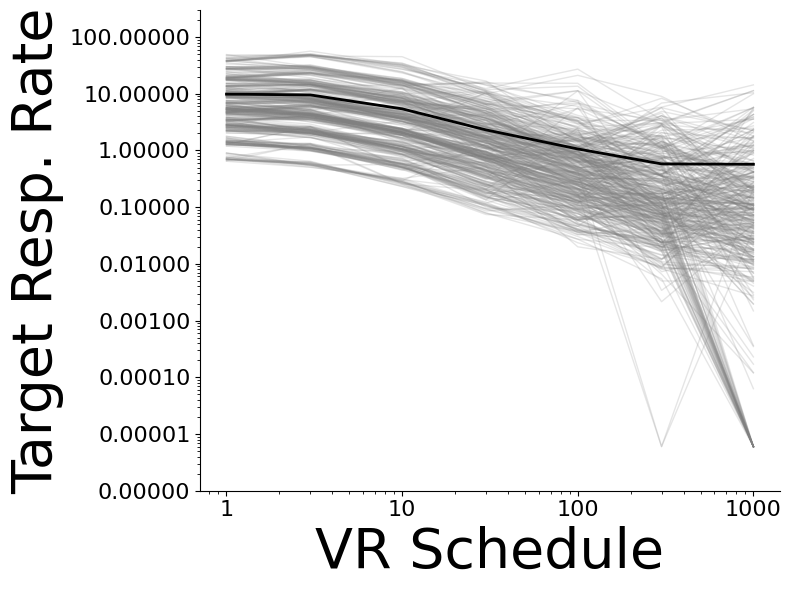

In [5]:
# Sort the data so each AO's line is plotted in VR sequence order
results_df_sorted = results_df.sort_values(['AO_id', 'VR'])
results_df_sorted['b_target_avg'] = results_df_sorted['b_target_avg'].clip(lower=0.0000001)
results_df_sorted['b_target_avg'] = results_df_sorted['b_target_avg']*60

# Set up the figure
fig, ax = plt.subplots(figsize=(8, 6))

# Plot each AO's line
for _, ao_data in results_df_sorted.groupby("AO_id"):
    ax.plot(
        ao_data['VR'],
        ao_data['b_target_avg'],
        color='gray',
        alpha=0.2,
        linewidth=1
    )

# Optional: Overlay a central tendency (e.g., median or mean line)
avg_data = results_df_sorted.groupby('VR')['b_target_avg'].mean().reset_index()
sns.lineplot(
    data=avg_data,
    x='VR', y='b_target_avg',
    color='black',
    linewidth=2,
    label='Mean across AOs'
)

# Log scales for both axes
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylim(0.000001, 300)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.5f'))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))

# Labels and style
ax.set_ylabel("Target Resp. Rate", fontsize=40)
ax.set_xlabel("VR Schedule", fontsize=40)
ax.legend().remove()
ax.grid(False)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
sns.despine()
plt.tight_layout()
plt.show()

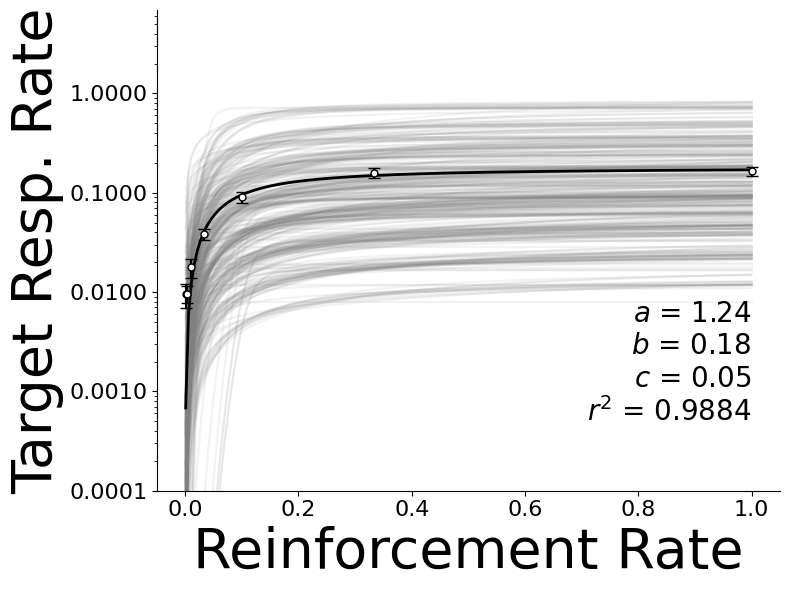

In [6]:
# Compute reinforcement rate
results_df['r'] = 1 / results_df['VR']
results_df['b_target_avg'] = results_df['b_target_avg']

# Define generalized hyperbola
def generalized_hyperbola(r, a, b, c):
    return (b * (r ** a)) / (r ** a + c)

# Fit function per AO
def fit_ao_hyperbola(df):
    try:
        popt, _ = curve_fit(
            generalized_hyperbola,
            df['r'],
            df['b_target_avg'],
            p0=[1.0, 1.0, 0.1],
            bounds=(0, np.inf),
            maxfev=10000
        )
        return popt
    except:
        return [np.nan, np.nan, np.nan]

# Fit and store per-AO curves
fit_results = []
ao_curves = []

# Loop over AOs
for ao_id, group in results_df.groupby("AO_id"):
    try:
        # Fit hyperbola
        popt, _ = curve_fit(
            generalized_hyperbola,
            group['r'],
            group['b_target_avg'],
            p0=[1.0, 1.0, 0.1],
            bounds=(0, np.inf),
            maxfev=10000
        )

        # Predict using the fit
        predicted = generalized_hyperbola(group['r'], *popt)

        # Compute R²
        residuals = group['b_target_avg'] - predicted
        ss_res = np.sum(residuals ** 2)
        ss_tot = np.sum((group['b_target_avg'] - np.mean(group['b_target_avg'])) ** 2)
        r_squared = 1 - (ss_res / ss_tot)

        # Store parameters and R²
        fit_results.append({
            'AO_id': ao_id,
            'a': popt[0],
            'b': popt[1],
            'c': popt[2],
            'r_squared': r_squared
        })

        # Store predicted curve
        r_vals = np.linspace(group['r'].min(), group['r'].max(), 200)
        predicted_curve = generalized_hyperbola(r_vals, *popt)
        ao_curves.append(pd.DataFrame({
            'AO_id': ao_id,
            'r': r_vals,
            'predicted_b_target': predicted_curve
        }))

    except:
        continue  # skip AOs that fail to fit

fit_df = pd.DataFrame(fit_results)
curves_df = pd.concat(ao_curves, ignore_index=True)

# Group-level mean and CI
grouped = results_df.groupby('r').agg(
    b_target_avg_mean=('b_target_avg', 'mean'),
    b_target_avg_se=('b_target_avg', sem)
).reset_index()
grouped['b_target_avg_ci'] = grouped['b_target_avg_se'] * t.ppf(0.975, df=len(results_df) - 1)

# Fit group-level curve
popt, _ = curve_fit(
    generalized_hyperbola,
    grouped['r'],
    grouped['b_target_avg_mean'],
    p0=[1.0, 1.0, 0.1],
    bounds=(0, np.inf)
)
r_vals = np.linspace(grouped['r'].min(), grouped['r'].max(), 200)
group_fit = generalized_hyperbola(r_vals, *popt)

# R² calculation for group-level fit
residuals = grouped['b_target_avg_mean'] - generalized_hyperbola(grouped['r'], *popt)
ss_res = np.sum(residuals ** 2)
ss_tot = np.sum((grouped['b_target_avg_mean'] - np.mean(grouped['b_target_avg_mean'])) ** 2)
r_squared = 1 - (ss_res / ss_tot)

# Plot
plt.figure(figsize=(8, 6))

# Plot all individual AO fits
for ao_id, ao_curve in curves_df.groupby("AO_id"):
    plt.plot(ao_curve['r'], ao_curve['predicted_b_target'], alpha=0.1, color='gray')

# Plot group-level fit
plt.plot(r_vals, group_fit, color='black', linewidth=2, label='Group Mean Fit')

# Overlay mean ± CI as white points with black outlines
plt.errorbar(
    grouped['r'],
    grouped['b_target_avg_mean'],
    yerr=grouped['b_target_avg_ci'],
    fmt='o',
    color='white',
    markersize=5,
    elinewidth=1.5,
    ecolor='black',
    capsize=4,
    markeredgecolor='black',
    label='Mean ± 95% CI'
)

# Add annotation for group-level fit parameters
plt.text(
    x=1,
    y=0.0005,
    s=f"$a$ = {popt[0]:.2f}\n$b$ = {popt[1]:.2f}\n$c$ = {popt[2]:.2f}\n$r^2$ = {r_squared:.4f}",
    fontsize=20,
    ha='right'
)

# Style
plt.yscale("log")
plt.xlabel("Reinforcement Rate", fontsize=40)
plt.ylabel("Target Resp. Rate", fontsize=40)
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.4f'))
plt.legend().remove()
plt.ylim(.0001, )
plt.grid(False)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
sns.despine()
plt.tight_layout()
plt.show()

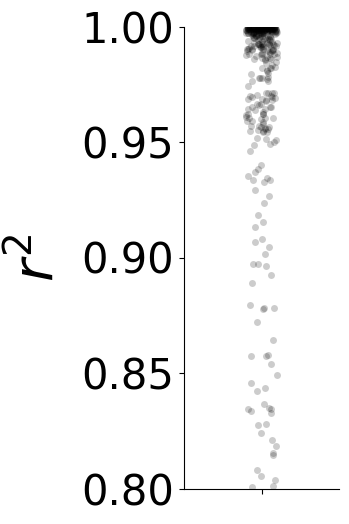

In [7]:
fig, ax = plt.subplots(figsize=(2, 6))
sns.stripplot(fit_df['r_squared'], color='k', alpha=0.2)
sns.despine(top=True, right=True)
plt.ylabel(r"$r^2$", fontsize=40, labelpad=12)
plt.yticks(ticks=[0.8, 0.85, 0.9, 0.95, 1.0], fontsize=30)
ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
plt.ylim(0.8, 1)
plt.show()

In [8]:
# for vr_val in results_df['VR'].unique():
#   df_vr = results_df[results_df['VR'] == vr_val]

#   # Metric column mapping
#   metrics = {
#       'arousal_avg': ('Arousal', 'arousal_ci'),
#       'coupling_avg': ('Coupling', 'coupling_ci'),
#       'b_target_avg': ('Target Response Rate', 'b_target_ci'),
#       'b_total_avg': ('Total Response Rate', 'b_total_ci')
#   }

#   params = ['activation', 'delta', 'alpha', 'eta']

#   # Create 4x4 subplot grid
#   fig, axs = plt.subplots(4, 4, figsize=(14, 14), sharex='col', sharey=False)
#   fig.subplots_adjust(hspace=0.4, wspace=0.4)

#   # Plot each metric × parameter
#   for row_idx, (metric_col, (metric_label, ci_col)) in enumerate(metrics.items()):
#       for col_idx, param in enumerate(params):
#           ax = axs[row_idx, col_idx]

#           # Get data for this combo
#           sub_df = df_vr[[param, metric_col, ci_col]].copy()

#           # Convert the x (param) to categorical codes for spacing
#           sub_df['x_val'] = pd.Categorical(sub_df[param]).codes
#           x_jittered = sub_df['x_val'] + np.random.uniform(-0.2, 0.2, size=len(sub_df))

#           # Plot strip manually
#           ax.scatter(x_jittered, sub_df[metric_col], color='black', alpha=0.7, s=15, zorder=2)

#           # Plot error bars (CIs)
#           ax.errorbar(
#               x_jittered,
#               sub_df[metric_col],
#               yerr=sub_df[ci_col],
#               fmt='none',
#               ecolor='gray',
#               elinewidth=0.8,
#               capsize=2,
#               alpha=0.6,
#               zorder=1
#           )

#           # Add symbolic labels
#           param_symbols = {
#               'activation': 'Activation',
#               'delta': r'$\delta$',
#               'alpha': r'$\alpha$',
#               'eta': r'$\eta$'
#           }

#           # Format axes
#           if row_idx == 3:
#               ax.set_xlabel(param_symbols[param], fontsize=20, labelpad=8, color='k')
#               ax.set_xticks(range(len(sub_df[param].unique())))
#               ax.set_xticklabels(sorted(sub_df[param].unique()), fontsize=10, color='k')
#           else:
#               ax.set_xlabel("")
#               ax.set_xticklabels([])
#               ax.tick_params(labelbottom=False)

#           if col_idx == 0:
#               ax.set_ylabel(metric_label, fontsize=20, labelpad=8, color='k')
#           else:
#               ax.set_ylabel("")
#               ax.set_yticklabels([])

#           ax.grid(False)
#           sns.despine(top=True, right=True)

#   plt.tight_layout(rect=[0, 0, 1, 0.97])
#   plt.suptitle(f"VR Schedule = {vr_val}", fontsize=20)
#   plt.show()


# A Range of Single VI Schedules

In [9]:
# --- MPR Model Equations ---
def update_arousal(prev_arousal: float, reinforcement: int, alpha: float, a: float) -> float:
    return alpha * (a * reinforcement) + (1 - alpha) * prev_arousal

def compute_total_response_rate(A: float, delta: float) -> float:
    return (1 / delta) * (A / (1 + A))

def compute_target_response_rate(A: float, delta: float, coupling: float) -> float:
    return coupling * (1 / delta) * (A / (1 + A))

def compute_c_star_vi(reinforcement_rate, rho=0.6, k=1.0, epsilon=0.8):
    """Compute asymptotic coupling for VI schedules."""
    return rho * (reinforcement_rate / (reinforcement_rate + k)) * epsilon

def update_coupling(prev_coupling: float, c_star: float, learning_rate: float = 0.05) -> float:
    """Update coupling toward schedule-sensitive asymptote."""
    return prev_coupling + learning_rate * (c_star - prev_coupling)

def update_step(prev_arousal, prev_coupling, reinforcement, a, delta, alpha, eta,
                reinforcement_rate, rho=0.6, k=1.0, epsilon=0.8):
    """Schedule-aware update step for VI schedules."""
    A = update_arousal(prev_arousal, reinforcement, alpha, a)
    C_star = compute_c_star_vi(reinforcement_rate, rho, k, epsilon)
    C = update_coupling(prev_coupling, C_star, learning_rate=eta)
    b_total = compute_total_response_rate(A, delta)
    b_target = compute_target_response_rate(A, delta, C)
    return A, C, b_total, b_target


# --- CI Helper ---
def ci95(data):
    n = len(data)
    return sem(data) * t.ppf(0.975, n - 1)

# --- Updated AO Simulation for Sequential VI ---
def simulate_mpr_vi_sequence(vi_schedule_list, a, delta, alpha, eta, ao_id,
                             steps_per_schedule=1000, avg_peck_rate=2.5,
                             rho=0.6, k=1.0, epsilon=0.8):

    A, C = 0.6, 0.5
    all_results = []

    for vi_idx, vi_sec in enumerate(vi_schedule_list):
        A_hist, C_hist, bt_hist, bp_hist = [], [], [], []
        reinforcement_history = []

        avg_irt = 1.0 / avg_peck_rate
        vi_times = np.cumsum(np.random.exponential(scale=vi_sec, size=steps_per_schedule))
        current_time = 0
        next_reinforcement_time = vi_times[0]
        vi_index = 0

        for _ in range(steps_per_schedule):
            current_time += avg_irt
            reinforcement = 0
            if current_time >= next_reinforcement_time:
                reinforcement = 1
                vi_index += 1
                if vi_index < len(vi_times):
                    next_reinforcement_time = vi_times[vi_index]
            reinforcement_history.append(reinforcement)

            # Compute reinforcement rate over a moving window
            window = 50
            recent = reinforcement_history[-window:]
            reinforcement_rate = sum(recent) / window

            # Run update step using schedule-sensitive coupling
            A, C, b_total, b_target = update_step(
                A, C, reinforcement, a, delta, alpha, eta,
                reinforcement_rate=reinforcement_rate,
                rho=rho, k=k, epsilon=epsilon
            )

            A_hist.append(A)
            C_hist.append(C)
            bt_hist.append(b_total)
            bp_hist.append(b_target)

        all_results.append({
            'AO_id': ao_id,
            'vi_sequence_index': vi_idx,
            'VI': vi_sec,
            'arousal_avg': np.mean(A_hist),
            'arousal_min': np.min(A_hist),
            'arousal_max': np.max(A_hist),
            'arousal_ci': ci95(A_hist),
            'coupling_avg': np.mean(C_hist),
            'coupling_min': np.min(C_hist),
            'coupling_max': np.max(C_hist),
            'coupling_ci': ci95(C_hist),
            'b_total_avg': np.mean(bt_hist),
            'b_total_min': np.min(bt_hist),
            'b_total_max': np.max(bt_hist),
            'b_total_ci': ci95(bt_hist),
            'b_target_avg': np.mean(bp_hist),
            'b_target_min': np.min(bp_hist),
            'b_target_max': np.max(bp_hist),
            'b_target_ci': ci95(bp_hist),
            'activation': a,
            'delta': delta,
            'alpha': alpha,
            'eta': eta,
        })

    return all_results


# Parameters
deltas = [0.25, 0.50, 1.0, 2.0]
activations = [0.1, 0.2, 0.4, 0.8, 1.6]
alphas = [0.01, 0.03, 0.1, 0.3, 1.0]
etas = [0.01, 0.03, 0.3, 1.0]
vi_schedules = [1, 3, 10, 30, 100, 300, 1000]

# Run each AO across all VI schedules in random order
results_vi = []
grid = list(product(activations, deltas, alphas, etas))

for ao_id, (a, delta, alpha, eta) in enumerate(tqdm(grid, desc="Running AO simulations through VI schedules")):
    shuffled_vis = np.random.permutation(vi_schedules)
    sim_result_list = simulate_mpr_vi_sequence(shuffled_vis, a, delta, alpha, eta, ao_id=ao_id)
    results_vi.extend(sim_result_list)

# Final DataFrame
results_vi_df = pd.DataFrame(results_vi)

# Convert responses per sec to response per min
results_vi_df['b_target_avg'] = results_vi_df['b_target_avg']*60

Running AO simulations through VI schedules:   0%|          | 0/400 [00:00<?, ?it/s]

Running AO simulations through VI schedules: 100%|██████████| 400/400 [00:14<00:00, 26.87it/s]


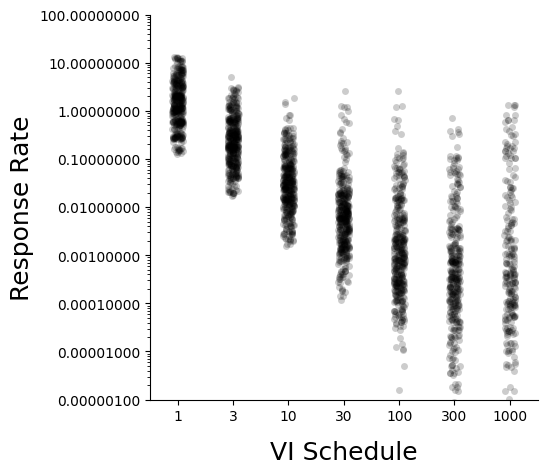

In [10]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.stripplot(
    x='VI',
    y='b_target_avg',
    data=results_vi_df,
    color='k',
    alpha=0.2
)
plt.yscale("log")
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.8f'))
plt.ylim(0.000001, 100)
ax.grid(False)
sns.despine(top=True, right=True)
plt.ylabel("Response Rate", fontsize=18)
plt.xlabel("VI Schedule", labelpad=12, fontsize=18)
plt.show()

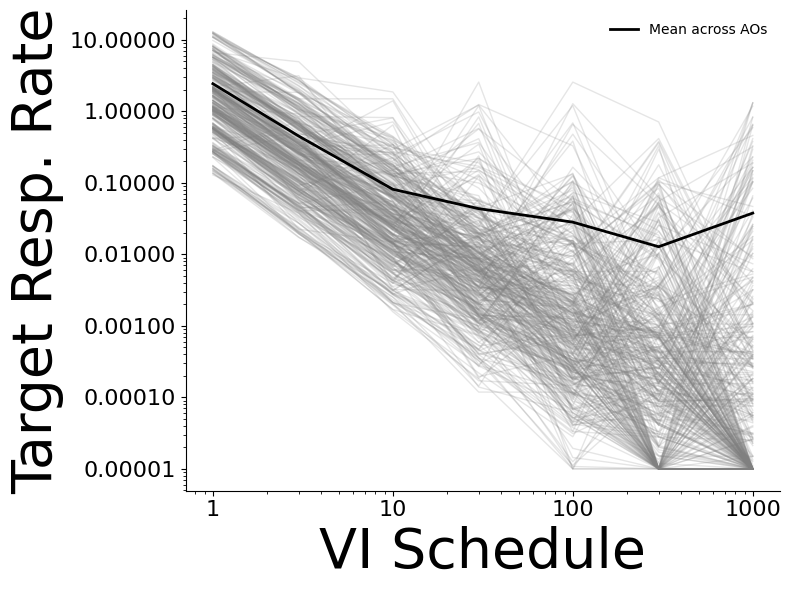

In [11]:
# Sort the data so each AO's line is plotted in VR sequence order
results_df_sorted = results_vi_df.sort_values(['AO_id', 'VI'])
results_df_sorted['b_target_avg'] = results_df_sorted['b_target_avg'].clip(lower=0.00001)

# Set up the figure
fig, ax = plt.subplots(figsize=(8, 6))

# Plot each AO's line
for _, ao_data in results_df_sorted.groupby("AO_id"):
    ax.plot(
        ao_data['VI'],
        ao_data['b_target_avg'],
        color='gray',
        alpha=0.2,
        linewidth=1
    )

# Optional: Overlay a central tendency (e.g., median or mean line)
avg_data = results_df_sorted.groupby('VI')['b_target_avg'].mean().reset_index()
sns.lineplot(
    data=avg_data,
    x='VI', y='b_target_avg',
    color='black',
    linewidth=2,
    label='Mean across AOs'
)

# Log scales for both axes
ax.set_yscale("log")
ax.set_xscale("log")
# ax.set_ylim(0.00001, 300)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.5f'))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))

# Labels and style
ax.set_ylabel("Target Resp. Rate", fontsize=40)
ax.set_xlabel("VI Schedule", fontsize=40)
ax.legend(frameon=False)
ax.grid(False)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
sns.despine()
plt.tight_layout()
plt.show()

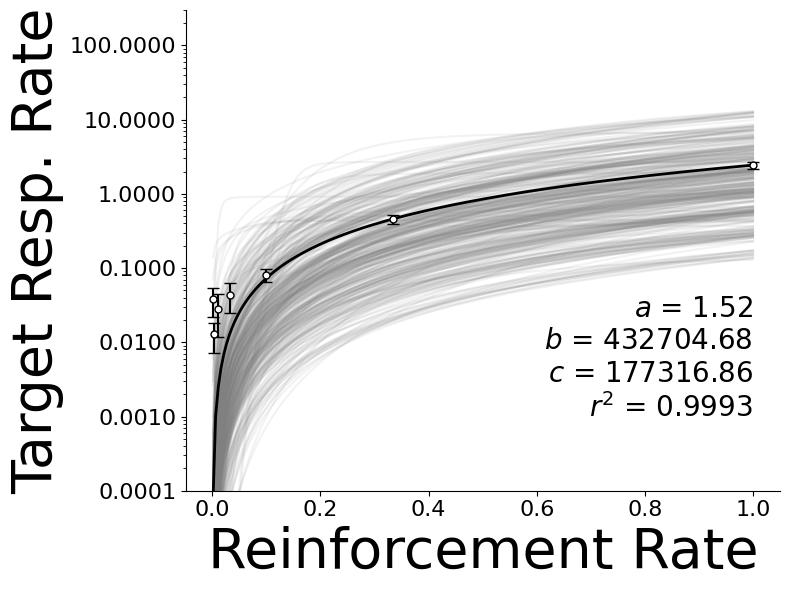

In [12]:
# Compute reinforcement rate
results_vi_df['r'] = 1 / results_vi_df['VI']

# Define generalized hyperbola
def generalized_hyperbola(r, a, b, c):
    return (b * (r ** a)) / (r ** a + c)

# Fit function per AO
def fit_ao_hyperbola(df):
    try:
        popt, _ = curve_fit(
            generalized_hyperbola,
            df['r'],
            df['b_target_avg'],
            p0=[1.0, 1.0, 0.1],
            bounds=(0, np.inf),
            maxfev=10000
        )
        return popt
    except:
        return [np.nan, np.nan, np.nan]

# Fit and store per-AO curves
fit_results = []
ao_curves = []

# Loop over AOs
for ao_id, group in results_vi_df.groupby("AO_id"):
    try:
        # Fit hyperbola
        popt, _ = curve_fit(
            generalized_hyperbola,
            group['r'],
            group['b_target_avg'],
            p0=[1.0, 1.0, 0.1],
            bounds=(0, np.inf),
            maxfev=10000
        )

        # Predict using the fit
        predicted = generalized_hyperbola(group['r'], *popt)

        # Compute R²
        residuals = group['b_target_avg'] - predicted
        ss_res = np.sum(residuals ** 2)
        ss_tot = np.sum((group['b_target_avg'] - np.mean(group['b_target_avg'])) ** 2)
        r_squared = 1 - (ss_res / ss_tot)

        # Store parameters and R²
        fit_results.append({
            'AO_id': ao_id,
            'a': popt[0],
            'b': popt[1],
            'c': popt[2],
            'r_squared': r_squared
        })

        # Store predicted curve
        r_vals = np.linspace(group['r'].min(), group['r'].max(), 200)
        predicted_curve = generalized_hyperbola(r_vals, *popt)
        ao_curves.append(pd.DataFrame({
            'AO_id': ao_id,
            'r': r_vals,
            'predicted_b_target': predicted_curve
        }))

    except:
        continue  # skip AOs that fail to fit

fit_df = pd.DataFrame(fit_results)
curves_df = pd.concat(ao_curves, ignore_index=True)

# Group-level mean and CI
grouped = results_vi_df.groupby('r').agg(
    b_target_avg_mean=('b_target_avg', 'mean'),
    b_target_avg_se=('b_target_avg', sem)
).reset_index()
grouped['b_target_avg_ci'] = grouped['b_target_avg_se'] * t.ppf(0.975, df=len(results_df) - 1)

# Fit group-level curve
popt, _ = curve_fit(
    generalized_hyperbola,
    grouped['r'],
    grouped['b_target_avg_mean'],
    p0=[1.0, 1.0, 0.1],
    bounds=(0, np.inf)
)
r_vals = np.linspace(grouped['r'].min(), grouped['r'].max(), 200)
group_fit = generalized_hyperbola(r_vals, *popt)

# R² calculation for group-level fit
residuals = grouped['b_target_avg_mean'] - generalized_hyperbola(grouped['r'], *popt)
ss_res = np.sum(residuals ** 2)
ss_tot = np.sum((grouped['b_target_avg_mean'] - np.mean(grouped['b_target_avg_mean'])) ** 2)
r_squared = 1 - (ss_res / ss_tot)

# Plot
plt.figure(figsize=(8, 6))

# Plot all individual AO fits
for ao_id, ao_curve in curves_df.groupby("AO_id"):
    plt.plot(ao_curve['r'], ao_curve['predicted_b_target'], alpha=0.1, color='gray')

# Plot group-level fit
plt.plot(r_vals, group_fit, color='black', linewidth=2, label='Group Mean Fit')

# Overlay mean ± CI as white points with black outlines
plt.errorbar(
    grouped['r'],
    grouped['b_target_avg_mean'],
    yerr=grouped['b_target_avg_ci'],
    fmt='o',
    color='white',
    markersize=5,
    elinewidth=1.5,
    ecolor='black',
    capsize=4,
    markeredgecolor='black',
    label='Mean ± 95% CI'
)

# Add annotation for group-level fit parameters
plt.text(
    x=1,
    y=0.001,
    s=f"$a$ = {popt[0]:.2f}\n$b$ = {popt[1]:.2f}\n$c$ = {popt[2]:.2f}\n$r^2$ = {r_squared:.4f}",
    fontsize=20,
    ha='right'
)

# Style
plt.yscale("log")
plt.xlabel("Reinforcement Rate", fontsize=40)
plt.ylabel("Target Resp. Rate", fontsize=40)
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.4f'))
plt.legend().remove()
plt.ylim(.0001, 300)
plt.grid(False)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
sns.despine()
plt.tight_layout()
plt.show()

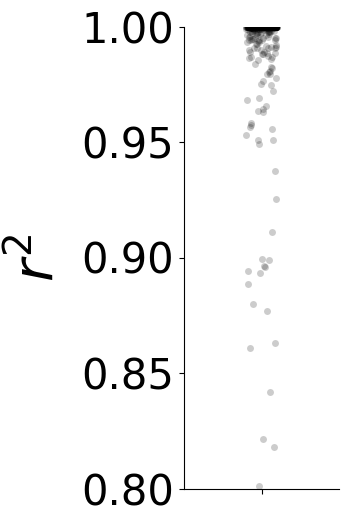

count    400.000000
mean       0.959912
std        0.138494
min        0.088958
25%        0.994509
50%        0.999806
75%        0.999988
max        1.000000
Name: r_squared, dtype: float64

In [13]:
fig, ax = plt.subplots(figsize=(2, 6))
sns.stripplot(fit_df['r_squared'], color='k', alpha=0.2)
sns.despine(top=True, right=True)
plt.ylabel(r"$r^2$", fontsize=40, labelpad=12)
plt.yticks(ticks=[0.8, 0.85, 0.9, 0.95, 1.0], fontsize=30)
ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
plt.ylim(0.8, 1)
plt.show()
fit_df['r_squared'].describe()

In [14]:
# for vi_focus in results_vi_df['VI'].unique():
#   df_vi = results_vi_df[results_vi_df['VI'] == vi_focus].copy()

#   # Metric → Label + CI column mapping
#   metrics_vi = {
#       'arousal_avg': ('Arousal', 'arousal_ci'),
#       'coupling_avg': ('Coupling', 'coupling_ci'),
#       'b_target_avg': ('Target Response Rate', 'b_target_ci'),
#       'b_total_avg': ('Total Response Rate', 'b_total_ci')
#   }

#   params = ['activation', 'delta', 'alpha', 'eta']

#   # Create 4x4 subplot grid
#   fig, axs = plt.subplots(4, 4, figsize=(14, 14), sharex='col', sharey=False)
#   fig.subplots_adjust(hspace=0.4, wspace=0.4)

#   # Plot each metric × parameter
#   for row_idx, (metric_col, (metric_label, ci_col)) in enumerate(metrics_vi.items()):
#       for col_idx, param in enumerate(params):
#           ax = axs[row_idx, col_idx]

#           # Get data for this combo
#           sub_df = df_vi[[param, metric_col, ci_col]].copy()

#           # Convert the x (param) to categorical codes for spacing
#           sub_df['x_val'] = pd.Categorical(sub_df[param]).codes
#           x_jittered = sub_df['x_val'] + np.random.uniform(-0.2, 0.2, size=len(sub_df))

#           # Plot strip manually
#           ax.scatter(x_jittered, sub_df[metric_col], color='black', alpha=0.7, s=15, zorder=2)

#           # Plot error bars (CIs)
#           ax.errorbar(
#               x_jittered,
#               sub_df[metric_col],
#               yerr=sub_df[ci_col],
#               fmt='none',
#               ecolor='gray',
#               elinewidth=0.8,
#               capsize=2,
#               alpha=0.6,
#               zorder=1
#           )

#           # Add symbolic labels
#           param_symbols = {
#               'activation': 'Activation',
#               'delta': r'$\delta$',
#               'alpha': r'$\alpha$',
#               'eta': r'$\eta$'
#           }

#           # Format axes
#           if row_idx == 3:
#               ax.set_xlabel(param_symbols[param], fontsize=20, labelpad=8, color='k')
#               ax.set_xticks(range(len(sub_df[param].unique())))
#               ax.set_xticklabels(sorted(sub_df[param].unique()), fontsize=10, color='k')
#           else:
#               ax.set_xlabel("")
#               ax.set_xticklabels([])
#               ax.tick_params(labelbottom=False)

#           if col_idx == 0:
#               ax.set_ylabel(metric_label, fontsize=20, labelpad=8, color='k')
#           else:
#               ax.set_ylabel("")
#               ax.set_yticklabels([])

#           ax.grid(False)
#           sns.despine(top=True, right=True)

#   plt.tight_layout(rect=[0, 0, 1, 0.97])
#   plt.suptitle(f"VI Schedule = {vi_focus}", fontsize=20)
#   plt.show()

# A Range of Concurrent VRs

In [15]:
# --- MPR Model Equations ---
def update_arousal(prev_arousal: float, reinforcement: int, alpha: float, a: float) -> float:
    return alpha * (a * reinforcement) + (1 - alpha) * prev_arousal

def compute_total_response_rate(A: float, delta: float) -> float:
    return (1 / delta) * (A / (1 + A))

def compute_target_response_rate(A: float, delta: float, coupling: float) -> float:
    return coupling * (1 / delta) * (A / (1 + A))

def compute_c_star_vr(vr_value, lambda_=0.3):
    """Compute schedule-sensitive coupling asymptote for VR schedule."""
    return 1 - math.exp(-lambda_ * vr_value)

def update_coupling(prev_coupling: float, c_star: float, learning_rate: float) -> float:
    """Recursive update toward C*."""
    return prev_coupling + learning_rate * (c_star - prev_coupling)

def update_step(prev_arousal, prev_coupling, reinforcement, a, delta, alpha, eta,
                schedule_param, lambda_=0.3):
    """Update arousal and schedule-sensitive coupling for VR schedules."""
    A = update_arousal(prev_arousal, reinforcement, alpha, a)
    C_star = compute_c_star_vr(schedule_param, lambda_=lambda_)
    C = update_coupling(prev_coupling, c_star=C_star, learning_rate=eta)
    b_total = compute_total_response_rate(A, delta)
    b_target = compute_target_response_rate(A, delta, C)
    return A, C, b_total, b_target

# --- CI Helper ---
def ci95(data):
    n = len(data)
    return sem(data) * t.ppf(0.975, n - 1)

# --- Simulation with Persistent State Across Concurrent VR Pairs ---
def simulate_concurrent_mpr_sequence(vr_pairs, a, delta, alpha, eta, ao_id, num_steps=1000, lambda_=0.3, cod_duration=6):
    A1, C1 = 0.6, 0.5
    A2, C2 = 0.6, 0.5
    all_results = []

    for pair_index, (vr1, vr2) in enumerate(vr_pairs):
        A1_hist, A2_hist = [], []
        C1_hist, C2_hist = [], []
        b1_hist, b2_hist = [], []

        # COD tracking
        last_choice = None
        steps_since_switch = cod_duration  # start eligible

        for _ in range(num_steps):
            # Choice rule
            p1 = C1 / (C1 + C2)
            choice = np.random.choice([1, 2], p=[p1, 1 - p1])

            # Detect switch
            if choice != last_choice:
                steps_since_switch = 0
                last_choice = choice
            else:
                steps_since_switch += 1

            # Simulate schedule availability
            r1 = int(np.random.rand() < (1 / vr1))
            r2 = int(np.random.rand() < (1 / vr2))

            # Determine eligibility based on COD
            eligible = steps_since_switch >= cod_duration
            reinforce1 = r1 if (choice == 1 and eligible) else 0
            reinforce2 = r2 if (choice == 2 and eligible) else 0

            # Update model
            if choice == 1:
                A1, C1, _, _ = update_step(A1, C1, reinforce1, a, delta, alpha, eta, schedule_param=vr1, lambda_=lambda_)
                A2 = update_arousal(A2, 0, alpha, a)
                C2_star = 1 - np.exp(-lambda_ * vr2)
                C2 = update_coupling(C2, C2_star, learning_rate=eta)
                b1_hist.append(1)
                b2_hist.append(0)
            else:
                A2, C2, _, _ = update_step(A2, C2, reinforce2, a, delta, alpha, eta, schedule_param=vr2, lambda_=lambda_)
                A1 = update_arousal(A1, 0, alpha, a)
                C1_star = 1 - np.exp(-lambda_ * vr1)
                C1 = update_coupling(C1, C1_star, learning_rate=eta)
                b1_hist.append(0)
                b2_hist.append(1)

            A1_hist.append(A1)
            A2_hist.append(A2)
            C1_hist.append(C1)
            C2_hist.append(C2)

        def ci95(data):
            return sem(data) * t.ppf(0.975, len(data) - 1)

        all_results.append({
            'AO_id': ao_id,
            'pair_index': pair_index,
            'VR1': vr1,
            'VR2': vr2,
            'reinforcement_ratio': np.round(vr2 / vr1, 2),
            'arousal1_avg': np.mean(A1_hist),
            'arousal2_avg': np.mean(A2_hist),
            'coupling1_avg': np.mean(C1_hist),
            'coupling2_avg': np.mean(C2_hist),
            'choice1_avg': np.mean(b1_hist),
            'choice2_avg': np.mean(b2_hist),
            'arousal1_ci': ci95(A1_hist),
            'arousal2_ci': ci95(A2_hist),
            'coupling1_ci': ci95(C1_hist),
            'coupling2_ci': ci95(C2_hist),
            'choice1_ci': ci95(b1_hist),
            'choice2_ci': ci95(b2_hist),
            'activation': a,
            'delta': delta,
            'alpha': alpha,
            'eta': eta,
            'COD_steps': cod_duration
        })

    return all_results


# Parameter Grid
deltas = [0.25, 0.50, 1.0, 2.0]
activations = [0.1, 0.2, 0.4, 0.8, 1.6]
alphas = [0.01, 0.03, 0.1, 0.3, 1.0]
etas = [0.01, 0.03, 0.3, 1.0]
vr_pairs = [(1, 9), (1, 3), (2, 2), (3, 1), (9, 1)]  # all pairs to be run per AO

# Run each AO through all VR pairs
concurrent_results = []
grid = list(product(activations, deltas, alphas, etas))

for ao_id, (a, delta, alpha, eta) in enumerate(tqdm(grid, desc="Running concurrent VR AOs")):
    sim_result_list = simulate_concurrent_mpr_sequence(vr_pairs, a, delta, alpha, eta, ao_id=ao_id)
    concurrent_results.extend(sim_result_list)

# Final DataFrame
results_concurrent_df = pd.DataFrame(concurrent_results)

Running concurrent VR AOs: 100%|██████████| 400/400 [00:57<00:00,  6.97it/s]


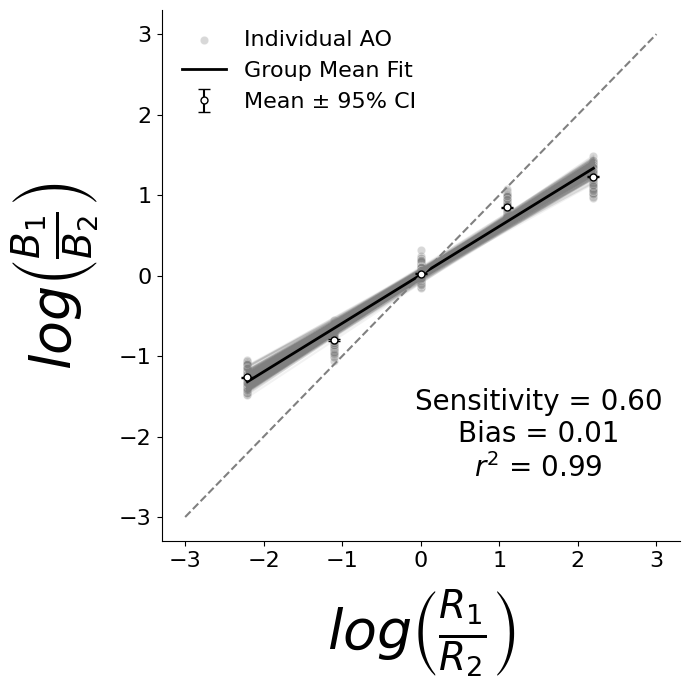

In [16]:
# Prep data
results_concurrent_df['response_ratio'] = results_concurrent_df['choice2_avg'] / results_concurrent_df['choice1_avg']
results_concurrent_df['log_resp_ratio'] = np.log(results_concurrent_df['response_ratio'])
results_concurrent_df['log_reinf_ratio'] = np.log(results_concurrent_df['reinforcement_ratio'])

# Fit matching law to each AO
ao_fits = []
ao_lines = []

for ao_id, group in results_concurrent_df.groupby("AO_id"):
    if group['log_reinf_ratio'].nunique() < 2:
        continue
    X = group[['log_reinf_ratio']]
    y = group['log_resp_ratio']
    model = LinearRegression().fit(X, y)
    slope = model.coef_[0]
    intercept = model.intercept_
    r2 = r2_score(y, model.predict(X))

    ao_fits.append({
        'AO_id': ao_id,
        'slope': slope,
        'intercept': intercept,
        'r_squared': r2
    })

    # Store line for plotting
    x_range = np.linspace(X.min(), X.max(), 100)
    ao_lines.append(pd.DataFrame({
        'AO_id': ao_id,
        'x': x_range.squeeze(),
        'y': model.predict(pd.DataFrame({'log_reinf_ratio': x_range.squeeze()}))
    }))

fit_df = pd.DataFrame(ao_fits)
ao_lines_df = pd.concat(ao_lines)

# Aggregate means across AOs per VR pair
grouped_means = results_concurrent_df.groupby(['VR1', 'VR2', 'reinforcement_ratio']).agg(
    log_resp_ratio_mean=('log_resp_ratio', 'mean'),
    log_resp_ratio_se=('log_resp_ratio', sem),
    log_reinf_ratio=('log_reinf_ratio', 'mean')
).reset_index()

grouped_means['log_resp_ratio_ci'] = grouped_means['log_resp_ratio_se'] * t.ppf(0.975, df=len(results_concurrent_df) - 1)

# Fit matching law to group means
X_group = grouped_means[['log_reinf_ratio']]
y_group = grouped_means['log_resp_ratio_mean']

group_model = LinearRegression().fit(X_group, y_group)
group_slope = group_model.coef_[0]
group_intercept = group_model.intercept_
group_r2 = r2_score(y_group, group_model.predict(X_group))

x_range_group = np.linspace(X_group.min(), X_group.max(), 100)
y_pred_group = group_model.predict(pd.DataFrame({'log_reinf_ratio': x_range_group.squeeze()}))

# Plot everything
plt.figure(figsize=(7, 7))

# Gray points and individual AO fits
sns.scatterplot(
    x='log_reinf_ratio',
    y='log_resp_ratio',
    data=results_concurrent_df,
    color='gray',
    alpha=0.3,
    label='Individual AO'
)

for _, ao_line in ao_lines_df.groupby('AO_id'):
    plt.plot(ao_line['x'], ao_line['y'], color='gray', alpha=0.1)

# Mean ± 95% CI
plt.errorbar(
    x=grouped_means['log_reinf_ratio'],
    y=grouped_means['log_resp_ratio_mean'],
    yerr=grouped_means['log_resp_ratio_ci'],
    fmt='o',
    color='white',
    markersize=5,
    elinewidth=1.5,
    ecolor='black',
    capsize=4,
    markeredgecolor='black',
    label='Mean ± 95% CI'
)

# Group fit
plt.plot(x_range_group, y_pred_group, color='black', linewidth=2, label='Group Mean Fit')

# Identity line
plt.plot([-3, 3], [-3, 3], linestyle='--', color='gray')

# Labels and annotation
plt.xlabel(r'$\mathit{log}\left(\frac{R_1}{R_2}\right)$', fontsize=40, labelpad=12)
plt.ylabel(r'$\mathit{log}\left(\frac{B_1}{B_2}\right)$', fontsize=40, labelpad=12)

plt.text(
    1.5, -2.5,
    f"Sensitivity = {group_slope:.2f}\nBias = {group_intercept:.2f}\n$r^2$ = {group_r2:.2f}",
    fontsize=20,
    ha='center'
)

plt.legend(frameon=False, fontsize=16)
sns.despine(top=True, right=True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(False)
plt.tight_layout()
plt.show()


/var/folders/c5/vpx80swj4yb9ytlnrk8w2qnr0000gn/T/ipykernel_94767/4147746324.py:3: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.boxplot(fit_df['r_squared'], color='w', linecolor='gray')


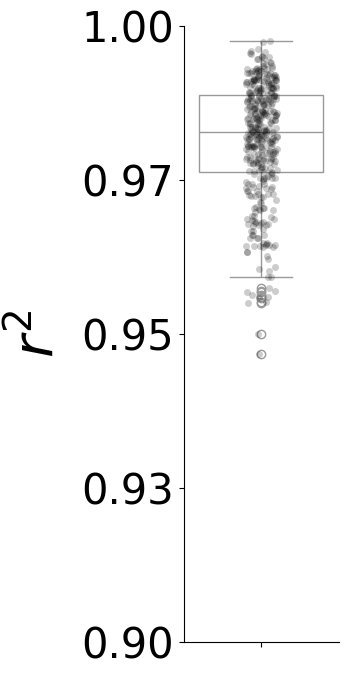

count    400.000000
mean       0.981435
std        0.009521
min        0.946808
25%        0.976392
50%        0.982829
75%        0.988748
max        0.997586
Name: r_squared, dtype: float64

In [17]:
fig, ax = plt.subplots(figsize=(2, 8))
sns.stripplot(fit_df['r_squared'], color='k', alpha=0.2)
sns.boxplot(fit_df['r_squared'], color='w', linecolor='gray')
sns.despine(top=True, right=True)
plt.ylabel(r"$r^2$", fontsize=40, labelpad=12)
plt.yticks(ticks=[0.9, 0.925, 0.95, 0.975, 1.0], fontsize=30)
ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
# plt.ylim(0.8, 1)
plt.show()
fit_df['r_squared'].describe()

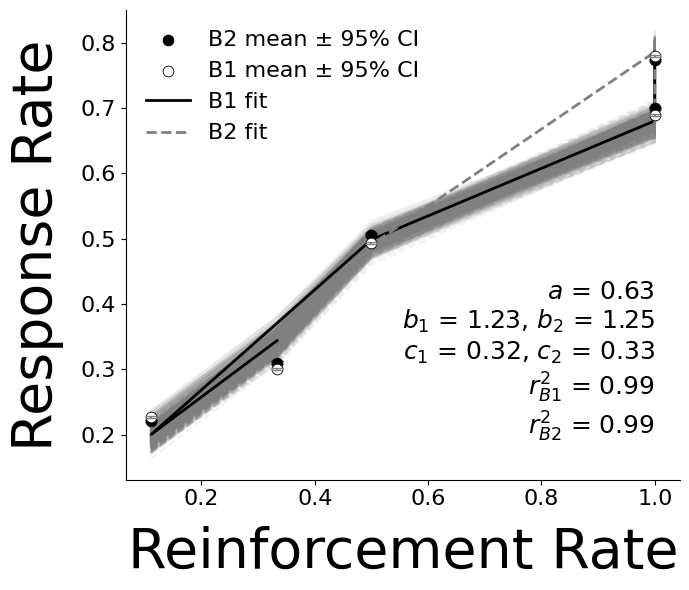

In [18]:
from scipy.optimize import least_squares

# Define McDowell concurrent schedule equations
def B1_eq(r1, r2, a, b1, c1, c2):
    return (b1 * (r1 ** a)) / (r1 ** a + (c1 / c2) * (r2 ** a) + c1)

def B2_eq(r1, r2, a, b2, c1, c2):
    return (b2 * (r2 ** a)) / ((c2 / c1) * (r1 ** a) + (r2 ** a) + c2)

# Joint residual function for least squares
def joint_residuals(params, r1, r2, B1_obs, B2_obs):
    a, b1, b2, c1, c2 = params
    B1_pred = B1_eq(r1, r2, a, b1, c1, c2)
    B2_pred = B2_eq(r1, r2, a, b2, c1, c2)
    return np.concatenate([(B1_pred - B1_obs), (B2_pred - B2_obs)])

# Prepare data
results_df = results_concurrent_df.copy()
results_df['r1'] = 1 / results_df['VR1']
results_df['r2'] = 1 / results_df['VR2']

# Fit per AO
fit_results = []
ao_fits = []

for ao_id, group in results_df.groupby("AO_id"):
    if group.shape[0] < 5:
        continue
    try:
        x0 = [1.0, 1.0, 1.0, 0.1, 0.1]
        res = least_squares(
            joint_residuals,
            x0=x0,
            bounds=(0, np.inf),
            args=(group['r1'].values, group['r2'].values, group['choice2_avg'].values, group['choice1_avg'].values)
        )
        a, b1, b2, c1, c2 = res.x

        # Compute predictions and R²
        B1_pred = B1_eq(group['r1'], group['r2'], a, b1, c1, c2)
        B2_pred = B2_eq(group['r1'], group['r2'], a, b2, c1, c2)
        r2_B1 = r2_score(group['choice1_avg'], B1_pred)
        r2_B2 = r2_score(group['choice2_avg'], B2_pred)

        fit_results.append({
            'AO_id': ao_id,
            'a': a, 'b1': b1, 'b2': b2, 'c1': c1, 'c2': c2,
            'r2_B1': r2_B1, 'r2_B2': r2_B2
        })

        ao_fits.append({
            'AO_id': ao_id,
            'r1': group['r1'].values,
            'r2': group['r2'].values,
            'B1_pred': B1_pred,
            'B2_pred': B2_pred
        })
    except:
        continue

fit_df = pd.DataFrame(fit_results)

# Group means and CI
grouped = results_df.groupby(['VR1', 'VR2']).agg({
    'r1': 'mean',
    'r2': 'mean',
    'choice1_avg': ['mean', sem],
    'choice2_avg': ['mean', sem]
}).reset_index()

grouped.columns = ['VR1', 'VR2', 'r1', 'r2', 'B1_mean', 'B1_se', 'B2_mean', 'B2_se']
grouped['B1_ci'] = grouped['B1_se'] * t.ppf(0.975, df=len(results_df) - 1)
grouped['B2_ci'] = grouped['B2_se'] * t.ppf(0.975, df=len(results_df) - 1)

# Fit model to group means
x0 = [1.0, 1.0, 1.0, 0.1, 0.1]
res = least_squares(
    joint_residuals,
    x0=x0,
    bounds=(0, np.inf),
    args=(grouped['r1'].values, grouped['r2'].values, grouped['B2_mean'].values, grouped['B1_mean'].values)
)
a, b1, b2, c1, c2 = res.x

grouped['B1_pred'] = B1_eq(grouped['r2'], grouped['r1'], a, b1, c1, c2)
grouped['B2_pred'] = B2_eq(grouped['r2'], grouped['r1'], a, b2, c1, c2)

r2_B1 = r2_score(grouped['B1_mean'], grouped['B1_pred'])
r2_B2 = r2_score(grouped['B2_mean'], grouped['B2_pred'])

# Plot
plt.figure(figsize=(7, 6))

# All AO lines in gray
for fit in ao_fits:
    plt.plot(fit['r1'], fit['B1_pred'], color='gray', alpha=0.1, zorder=1)
    plt.plot(fit['r2'], fit['B2_pred'], color='gray', alpha=0.1, linestyle='--', zorder=1)

# Mean data points with CI
sns.scatterplot(x=grouped['r1'], y=grouped['B2_mean'], color='black', edgecolor='black', s=60,
                label='B2 mean ± 95% CI', zorder=10)
plt.errorbar(grouped['r1'], grouped['B2_mean'], yerr=grouped['B2_ci'], fmt='none',
             ecolor='black', capsize=4, zorder=10)

sns.scatterplot(x=grouped['r2'], y=grouped['B1_mean'], color='white', edgecolor='black', s=60,
                label='B1 mean ± 95% CI', zorder=10)
plt.errorbar(grouped['r2'], grouped['B1_mean'], yerr=grouped['B1_ci'], fmt='none',
             ecolor='gray', capsize=4, zorder=10)

# Group fits in bold
plt.plot(grouped['r2'], grouped['B1_pred'], color='black', linewidth=2,
         label='B1 fit', zorder=9)
plt.plot(grouped['r1'], grouped['B2_pred'], color='gray', linewidth=2, linestyle='--',
         label='B2 fit', zorder=9)

# Annotation
plt.text(
    1, 0.2,
    f"$a$ = {a:.2f}\n"
    f"$b_1$ = {b1:.2f}, $b_2$ = {b2:.2f}\n"
    f"$c_1$ = {c1:.2f}, $c_2$ = {c2:.2f}\n"
    f"$r^2_{{B1}}$ = {r2_B1:.2f}\n"
    f"$r^2_{{B2}}$ = {r2_B2:.2f}",
    fontsize=18,
    ha='right'
)

plt.xlabel('Reinforcement Rate', fontsize=40, labelpad=12)
plt.ylabel('Response Rate', fontsize=40, labelpad=12)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.legend(frameon=False, fontsize=16)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()


In [19]:
# Prepare data for concurrent schedule version of the same 4x4 grid plot
params = ['activation', 'delta', 'alpha', 'eta']

# Mapping for each lever's metrics
metrics_concurrent_1 = {
    'arousal1_avg': (r'Arousal ($\it{B}_{1}$)', 'arousal1_ci'),
    'coupling1_avg': (r'Coupling ($\it{B}_{1}$)', 'coupling1_ci'),
    'choice1_avg': (r'Choice Rate ($\it{B}_{1}$)', 'choice1_ci'),
}

metrics_concurrent_2 = {
    'arousal2_avg': (r'Arousal ($\it{B}_{2}$)', 'arousal2_ci'),
    'coupling2_avg': (r'Coupling ($\it{B}_{2}$)', 'coupling2_ci'),
    'choice2_avg': (r'Choice Rate ($\it{B}_{2}$)', 'choice2_ci'),
}

In [20]:
# # Create subplot function
# def plot_concurrent_grid(df, metrics, title):
#     fig, axs = plt.subplots(3, 4, figsize=(16, 14), sharex='col', sharey=False)
#     fig.subplots_adjust(hspace=0.4, wspace=0.4)

#     for row_idx, (metric_col, (metric_label, ci_col)) in enumerate(metrics.items()):
#         for col_idx, param in enumerate(params):
#             ax = axs[row_idx, col_idx]
#             if metric_col == '':  # Skip empty row
#                 ax.axis('off')
#                 continue

#             sub_df = df[[param, metric_col, ci_col]].copy()
#             sub_df['x_val'] = pd.Categorical(sub_df[param]).codes
#             x_jittered = sub_df['x_val'] + np.random.uniform(-0.2, 0.2, size=len(sub_df))

#             ax.scatter(x_jittered, sub_df[metric_col], color='black', alpha=0.7, s=15, zorder=2)
#             ax.errorbar(
#                 x_jittered,
#                 sub_df[metric_col],
#                 yerr=sub_df[ci_col],
#                 fmt='none',
#                 ecolor='gray',
#                 elinewidth=0.8,
#                 capsize=2,
#                 alpha=0.6,
#                 zorder=1
#             )

#             # Add symbolic labels
#             param_symbols = {
#                 'activation': 'Activation',
#                 'delta': r'$\delta$',
#                 'alpha': r'$\alpha$',
#                 'eta': r'$\eta$'
#             }

#             # Format axes
#             if row_idx == 2:
#                 ax.set_xlabel(param_symbols[param], fontsize=20, labelpad=8, color='k')
#                 ax.set_xticks(range(len(sub_df[param].unique())))
#                 ax.set_xticklabels(sorted(sub_df[param].unique()), fontsize=10, color='k')
#             else:
#                 ax.set_xlabel("")
#                 ax.set_xticklabels([])
#                 ax.tick_params(labelbottom=False)

#             if col_idx == 0:
#                 ax.set_ylabel(metric_label, fontsize=20, labelpad=8, color='k')
#             else:
#                 ax.set_ylabel("")
#                 ax.set_yticklabels([])

#             ax.grid(False)
#             sns.despine(top=True, right=True)

#     plt.suptitle(title, fontsize=30)
#     plt.tight_layout(rect=[0, 0, 1, 0.97])
#     plt.show()



In [21]:
# Plot Lever 1
# plot_concurrent_grid(results_concurrent_df, metrics_concurrent_1, r"Concurrent Schedule: $\it{B}_{1}$")

In [22]:
# Plot Lever 2
# plot_concurrent_grid(results_concurrent_df, metrics_concurrent_2, r"Concurrent Schedule: $\it{B}_{2}$")

# A Range of Concurrent VIs

In [23]:
# --- MPR Model Equations ---
def update_arousal(prev_arousal, reinforcement, alpha, a):
    return alpha * (a * reinforcement) + (1 - alpha) * prev_arousal

def compute_total_response_rate(A, delta):
    return (1 / delta) * (A / (1 + A))

def compute_target_response_rate(A, delta, coupling):
    return coupling * (1 / delta) * (A / (1 + A))

def compute_c_star_vi(reinforcement_rate, rho=0.6, k=1.0, epsilon=0.8):
    return rho * (reinforcement_rate / (reinforcement_rate + k)) * epsilon

def update_coupling(prev_coupling: float, c_star: float, learning_rate: float):
    return prev_coupling + learning_rate * (c_star - prev_coupling)

def update_step(prev_arousal, prev_coupling, reinforcement, a, delta, alpha, eta,
                reinforcement_rate, rho=0.6, k=1.0, epsilon=0.8):
    A = update_arousal(prev_arousal, reinforcement, alpha, a)
    C_star = compute_c_star_vi(reinforcement_rate, rho, k, epsilon)
    C = update_coupling(prev_coupling, C_star, learning_rate=eta)
    b_total = compute_total_response_rate(A, delta)
    b_target = compute_target_response_rate(A, delta, C)
    return A, C, b_total, b_target

# --- Concurrent VI Sequence Simulation (AO across all VI pairs) ---
def simulate_concurrent_mpr_vi_sequence(vi_pairs, a, delta, alpha, eta, ao_id,
                                        num_steps=1000, avg_peck_rate=2.5,
                                        rho=0.6, k=1.0, epsilon=0.8):
    A1, C1 = 0.6, 0.5
    A2, C2 = 0.6, 0.5
    results = []

    for pair_index, (vi1, vi2) in enumerate(vi_pairs):
        A1_hist, A2_hist, C1_hist, C2_hist = [], [], [], []
        b1_hist, b2_hist = [], []
        r1_hist, r2_hist = [], []

        avg_irt = 1.0 / avg_peck_rate
        vi_times1 = np.cumsum(np.random.exponential(scale=vi1, size=num_steps))
        vi_times2 = np.cumsum(np.random.exponential(scale=vi2, size=num_steps))
        t1_index, t2_index = 0, 0
        next_r1, next_r2 = vi_times1[0], vi_times2[0]
        current_time = 0

        for _ in range(num_steps):
            current_time += avg_irt
            r1 = int(current_time >= next_r1)
            r2 = int(current_time >= next_r2)

            if r1 and t1_index + 1 < len(vi_times1):
                t1_index += 1
                next_r1 = vi_times1[t1_index]
            if r2 and t2_index + 1 < len(vi_times2):
                t2_index += 1
                next_r2 = vi_times2[t2_index]

            # Moving average reinforcement rate (window=50)
            r1_hist.append(r1)
            r2_hist.append(r2)
            r1_rate = sum(r1_hist[-50:]) / 50
            r2_rate = sum(r2_hist[-50:]) / 50

            # Choice
            denom = C1 + C2
            p1 = C1 / denom if denom > 0 else 0.5
            choice = np.random.choice([1, 2], p=[p1, 1 - p1])

            if choice == 1:
                A1, C1, _, _ = update_step(A1, C1, r1, a, delta, alpha, eta,
                                           reinforcement_rate=r1_rate, rho=rho, k=k, epsilon=epsilon)
                A2 = update_arousal(A2, 0, alpha, a)
                C2_star = compute_c_star_vi(r2_rate, rho, k, epsilon)
                C2 = update_coupling(C2, C2_star, learning_rate=eta)
                b1_hist.append(1)
                b2_hist.append(0)
            else:
                A2, C2, _, _ = update_step(A2, C2, r2, a, delta, alpha, eta,
                                           reinforcement_rate=r2_rate, rho=rho, k=k, epsilon=epsilon)
                A1 = update_arousal(A1, 0, alpha, a)
                C1_star = compute_c_star_vi(r1_rate, rho, k, epsilon)
                C1 = update_coupling(C1, C1_star, learning_rate=eta)
                b1_hist.append(0)
                b2_hist.append(1)

            A1_hist.append(A1)
            A2_hist.append(A2)
            C1_hist.append(C1)
            C2_hist.append(C2)

        def ci95(data):
            return sem(data) * t.ppf(0.975, len(data) - 1)

        results.append({
            'AO_id': ao_id,
            'pair_index': pair_index,
            'VI1': vi1,
            'VI2': vi2,
            'reinforcement_ratio': round(vi2 / vi1, 2),
            'arousal1_avg': np.mean(A1_hist),
            'arousal2_avg': np.mean(A2_hist),
            'coupling1_avg': np.mean(C1_hist),
            'coupling2_avg': np.mean(C2_hist),
            'choice1_avg': np.mean(b1_hist),
            'choice2_avg': np.mean(b2_hist),
            'arousal1_ci': ci95(A1_hist),
            'arousal2_ci': ci95(A2_hist),
            'coupling1_ci': ci95(C1_hist),
            'coupling2_ci': ci95(C2_hist),
            'choice1_ci': ci95(b1_hist),
            'choice2_ci': ci95(b2_hist),
            'activation': a,
            'delta': delta,
            'alpha': alpha,
            'eta': eta
        })

    return results


# Params
deltas = [0.25, 0.50, 1.0, 2.0]
activations = [0.1, 0.2, 0.4, 0.8, 1.6]
alphas = [0.01, 0.03, 0.1, 0.3, 1.0]
etas = [0.01, 0.03, 0.3, 1.0]
vi_pairs = [(1, 9), (1, 3), (2, 2), (3, 1), (9, 1)]

# Simulation
results_concurrent_vi = []
grid = list(product(activations, deltas, alphas, etas))

for ao_id, (a, delta, alpha, eta) in enumerate(tqdm(grid, desc="Concurrent VI AO sims")):
    shuffled_pairs = np.random.permutation(vi_pairs)
    result = simulate_concurrent_mpr_vi_sequence(shuffled_pairs, a, delta, alpha, eta, ao_id=ao_id)
    results_concurrent_vi.extend(result)

# Final DataFrame
results_concurrent_vi_df = pd.DataFrame(results_concurrent_vi)

Concurrent VI AO sims: 100%|██████████| 400/400 [00:59<00:00,  6.74it/s]


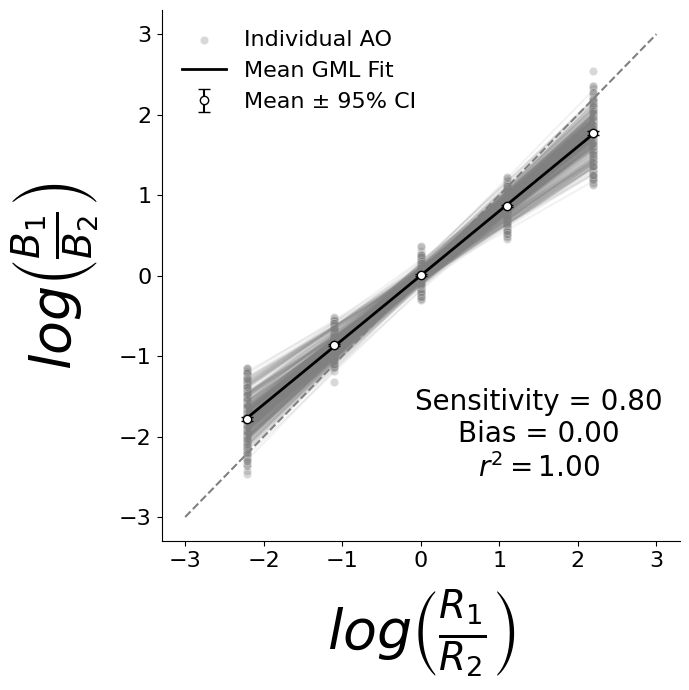

In [24]:
#Calculate log ratios
results_concurrent_vi_df['response_ratio'] = results_concurrent_vi_df['choice1_avg'] / results_concurrent_vi_df['choice2_avg']
results_concurrent_vi_df['log_resp_ratio'] = np.log(results_concurrent_vi_df['response_ratio'])
results_concurrent_vi_df['log_reinf_ratio'] = np.log(results_concurrent_vi_df['reinforcement_ratio'])

# Fit matching law per AO
ao_fits = []
ao_lines = []

for ao_id, group in results_concurrent_vi_df.groupby("AO_id"):
    if group['log_reinf_ratio'].nunique() < 2:
        continue
    X = group[['log_reinf_ratio']]
    y = group['log_resp_ratio']
    model = LinearRegression().fit(X, y)
    slope = model.coef_[0]
    intercept = model.intercept_
    r2 = r2_score(y, model.predict(X))

    ao_fits.append({'AO_id': ao_id, 'slope': slope, 'intercept': intercept, 'r_squared': r2})

    x_range = np.linspace(X.min(), X.max(), 100)
    ao_lines.append(pd.DataFrame({
        'AO_id': ao_id,
        'x': x_range.squeeze(),
        'y': model.predict(pd.DataFrame({'log_reinf_ratio': x_range.squeeze()}))
    }))

fit_df = pd.DataFrame(ao_fits)
ao_lines_df = pd.concat(ao_lines)

# Group-level mean + CI
grouped_means = results_concurrent_vi_df.groupby(['VI1', 'VI2', 'reinforcement_ratio']).agg(
    log_resp_ratio_mean=('log_resp_ratio', 'mean'),
    log_resp_ratio_se=('log_resp_ratio', sem),
    log_reinf_ratio=('log_reinf_ratio', 'mean')
).reset_index()

grouped_means['log_resp_ratio_ci'] = grouped_means['log_resp_ratio_se'] * t.ppf(0.975, df=len(results_concurrent_vi_df) - 1)

# Step 4: Fit group-level GML
X_group = grouped_means[['log_reinf_ratio']]
y_group = grouped_means['log_resp_ratio_mean']
model_group = LinearRegression().fit(X_group, y_group)
slope = model_group.coef_[0]
intercept = model_group.intercept_
r2 = r2_score(y_group, model_group.predict(X_group))

x_range_group = np.linspace(X_group.min(), X_group.max(), 100)
y_pred_group = model_group.predict(pd.DataFrame({'log_reinf_ratio': x_range_group.squeeze()}))

# Step 5: Plot
plt.figure(figsize=(7, 7))

# Individual AO data and fits
sns.scatterplot(
    x='log_reinf_ratio',
    y='log_resp_ratio',
    data=results_concurrent_vi_df,
    color='gray',
    alpha=0.3,
    label='Individual AO',
    zorder=1
)

for _, ao_line in ao_lines_df.groupby('AO_id'):
    plt.plot(ao_line['x'], ao_line['y'], color='gray', alpha=0.1, zorder=1)

# Group means with CI
plt.errorbar(
    x=grouped_means['log_reinf_ratio'],
    y=grouped_means['log_resp_ratio_mean'],
    yerr=grouped_means['log_resp_ratio_ci'],
    fmt='o',
    color='white',
    markersize=6,
    elinewidth=1.5,
    ecolor='black',
    capsize=4,
    markeredgecolor='black',
    label='Mean ± 95% CI',
    zorder=10
)

# Group-level GML line
plt.plot(x_range_group, y_pred_group, color='black', linewidth=2, label='Mean GML Fit', zorder=9)
plt.plot([-3, 3], [-3, 3], linestyle='--', color='gray', zorder=1)

# Labels and annotation
plt.xlabel(r'$\mathit{log}\left(\frac{R_1}{R_2}\right)$', fontsize=40, labelpad=12)
plt.ylabel(r'$\mathit{log}\left(\frac{B_1}{B_2}\right)$', fontsize=40, labelpad=12)

plt.text(
    1.5, -2.5,
    f"Sensitivity = {slope:.2f}\nBias = {intercept:.2f}\n$r^2 = {r2:.2f}$",
    fontsize=20,
    ha='center'
)

plt.grid(False)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(frameon=False, fontsize=16)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()


/var/folders/c5/vpx80swj4yb9ytlnrk8w2qnr0000gn/T/ipykernel_94767/4147746324.py:3: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.boxplot(fit_df['r_squared'], color='w', linecolor='gray')


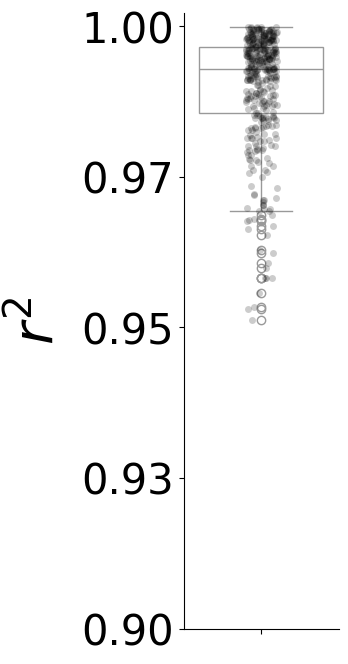

count    400.000000
mean       0.989872
std        0.009554
min        0.951232
25%        0.985550
50%        0.992979
75%        0.996546
max        0.999849
Name: r_squared, dtype: float64

In [25]:
fig, ax = plt.subplots(figsize=(2, 8))
sns.stripplot(fit_df['r_squared'], color='k', alpha=0.2)
sns.boxplot(fit_df['r_squared'], color='w', linecolor='gray')
sns.despine(top=True, right=True)
plt.ylabel(r"$r^2$", fontsize=40, labelpad=12)
plt.yticks(ticks=[0.9, 0.925, 0.95, 0.975, 1.0], fontsize=30)
ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
# plt.ylim(0.8, 1)
plt.show()
fit_df['r_squared'].describe()

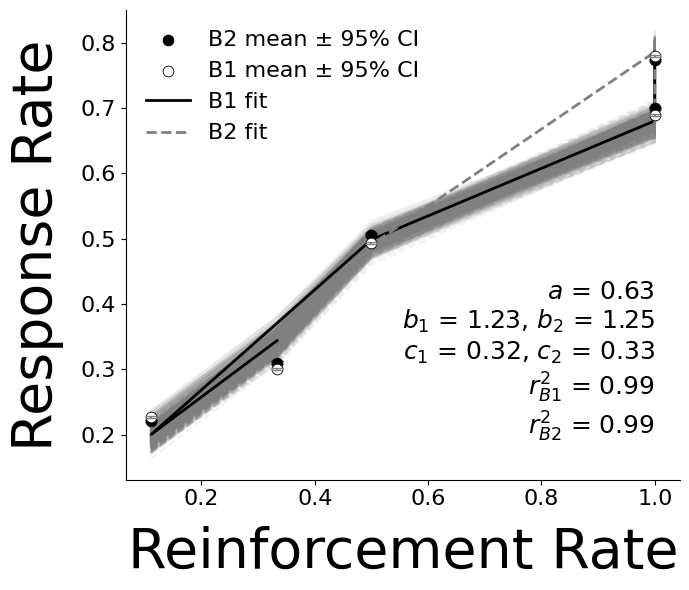

In [26]:
from scipy.optimize import least_squares

# Define McDowell concurrent schedule equations
def B1_eq(r1, r2, a, b1, c1, c2):
    return (b1 * (r1 ** a)) / (r1 ** a + (c1 / c2) * (r2 ** a) + c1)

def B2_eq(r1, r2, a, b2, c1, c2):
    return (b2 * (r2 ** a)) / ((c2 / c1) * (r1 ** a) + (r2 ** a) + c2)

# Joint residual function for least squares
def joint_residuals(params, r1, r2, B1_obs, B2_obs):
    a, b1, b2, c1, c2 = params
    B1_pred = B1_eq(r1, r2, a, b1, c1, c2)
    B2_pred = B2_eq(r1, r2, a, b2, c1, c2)
    return np.concatenate([(B1_pred - B1_obs), (B2_pred - B2_obs)])

# Prepare data
results_df = results_concurrent_df.copy()
results_df['r1'] = 1 / results_df['VR1']
results_df['r2'] = 1 / results_df['VR2']

# Fit per AO
fit_results = []
ao_fits = []

for ao_id, group in results_df.groupby("AO_id"):
    if group.shape[0] < 5:
        continue
    try:
        x0 = [1.0, 1.0, 1.0, 0.1, 0.1]
        res = least_squares(
            joint_residuals,
            x0=x0,
            bounds=(0, np.inf),
            args=(group['r1'].values, group['r2'].values, group['choice2_avg'].values, group['choice1_avg'].values)
        )
        a, b1, b2, c1, c2 = res.x

        # Compute predictions and R²
        B1_pred = B1_eq(group['r1'], group['r2'], a, b1, c1, c2)
        B2_pred = B2_eq(group['r1'], group['r2'], a, b2, c1, c2)
        r2_B1 = r2_score(group['choice1_avg'], B1_pred)
        r2_B2 = r2_score(group['choice2_avg'], B2_pred)

        fit_results.append({
            'AO_id': ao_id,
            'a': a, 'b1': b1, 'b2': b2, 'c1': c1, 'c2': c2,
            'r2_B1': r2_B1, 'r2_B2': r2_B2
        })

        ao_fits.append({
            'AO_id': ao_id,
            'r1': group['r1'].values,
            'r2': group['r2'].values,
            'B1_pred': B1_pred,
            'B2_pred': B2_pred
        })
    except:
        continue

fit_df = pd.DataFrame(fit_results)

# Group means and CI
grouped = results_df.groupby(['VR1', 'VR2']).agg({
    'r1': 'mean',
    'r2': 'mean',
    'choice1_avg': ['mean', sem],
    'choice2_avg': ['mean', sem]
}).reset_index()

grouped.columns = ['VR1', 'VR2', 'r1', 'r2', 'B1_mean', 'B1_se', 'B2_mean', 'B2_se']
grouped['B1_ci'] = grouped['B1_se'] * t.ppf(0.975, df=len(results_df) - 1)
grouped['B2_ci'] = grouped['B2_se'] * t.ppf(0.975, df=len(results_df) - 1)

# Fit model to group means
x0 = [1.0, 1.0, 1.0, 0.1, 0.1]
res = least_squares(
    joint_residuals,
    x0=x0,
    bounds=(0, np.inf),
    args=(grouped['r1'].values, grouped['r2'].values, grouped['B2_mean'].values, grouped['B1_mean'].values)
)
a, b1, b2, c1, c2 = res.x

grouped['B1_pred'] = B1_eq(grouped['r2'], grouped['r1'], a, b1, c1, c2)
grouped['B2_pred'] = B2_eq(grouped['r2'], grouped['r1'], a, b2, c1, c2)

r2_B1 = r2_score(grouped['B1_mean'], grouped['B1_pred'])
r2_B2 = r2_score(grouped['B2_mean'], grouped['B2_pred'])

# Plot
plt.figure(figsize=(7, 6))

# All AO lines in gray
for fit in ao_fits:
    plt.plot(fit['r1'], fit['B1_pred'], color='gray', alpha=0.1, zorder=1)
    plt.plot(fit['r2'], fit['B2_pred'], color='gray', alpha=0.1, linestyle='--', zorder=1)

# Mean data points with CI
sns.scatterplot(x=grouped['r1'], y=grouped['B2_mean'], color='black', edgecolor='black', s=60,
                label='B2 mean ± 95% CI', zorder=10)
plt.errorbar(grouped['r1'], grouped['B2_mean'], yerr=grouped['B2_ci'], fmt='none',
             ecolor='black', capsize=4, zorder=10)

sns.scatterplot(x=grouped['r2'], y=grouped['B1_mean'], color='white', edgecolor='black', s=60,
                label='B1 mean ± 95% CI', zorder=10)
plt.errorbar(grouped['r2'], grouped['B1_mean'], yerr=grouped['B1_ci'], fmt='none',
             ecolor='gray', capsize=4, zorder=10)

# Group fits in bold
plt.plot(grouped['r2'], grouped['B1_pred'], color='black', linewidth=2,
         label='B1 fit', zorder=9)
plt.plot(grouped['r1'], grouped['B2_pred'], color='gray', linewidth=2, linestyle='--',
         label='B2 fit', zorder=9)

# Annotation
plt.text(
    1, 0.2,
    f"$a$ = {a:.2f}\n"
    f"$b_1$ = {b1:.2f}, $b_2$ = {b2:.2f}\n"
    f"$c_1$ = {c1:.2f}, $c_2$ = {c2:.2f}\n"
    f"$r^2_{{B1}}$ = {r2_B1:.2f}\n"
    f"$r^2_{{B2}}$ = {r2_B2:.2f}",
    fontsize=18,
    ha='right'
)

plt.xlabel('Reinforcement Rate', fontsize=40, labelpad=12)
plt.ylabel('Response Rate', fontsize=40, labelpad=12)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.legend(frameon=False, fontsize=16)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()


In [27]:
# Prepare data for concurrent schedule version of the same 4x4 grid plot
params = ['activation', 'delta', 'alpha', 'eta']

# Mapping for each lever's metrics
metrics_concurrent_1 = {
    'arousal1_avg': (r'Arousal ($\it{B}_{1}$)', 'arousal1_ci'),
    'coupling1_avg': (r'Coupling ($\it{B}_{1}$)', 'coupling1_ci'),
    'choice1_avg': (r'Choice Rate ($\it{B}_{1}$)', 'choice1_ci'),
}

metrics_concurrent_2 = {
    'arousal2_avg': (r'Arousal ($\it{B}_{2}$)', 'arousal2_ci'),
    'coupling2_avg': (r'Coupling ($\it{B}_{2}$)', 'coupling2_ci'),
    'choice2_avg': (r'Choice Rate ($\it{B}_{2}$)', 'choice2_ci'),
}

In [28]:
# # Create subplot function
# def plot_concurrent_grid(df, metrics, title):
#     fig, axs = plt.subplots(3, 4, figsize=(16, 14), sharex='col', sharey=False)
#     fig.subplots_adjust(hspace=0.4, wspace=0.4)

#     for row_idx, (metric_col, (metric_label, ci_col)) in enumerate(metrics.items()):
#         for col_idx, param in enumerate(params):
#             ax = axs[row_idx, col_idx]
#             if metric_col == '':  # Skip empty row
#                 ax.axis('off')
#                 continue

#             sub_df = df[[param, metric_col, ci_col]].copy()
#             sub_df['x_val'] = pd.Categorical(sub_df[param]).codes
#             x_jittered = sub_df['x_val'] + np.random.uniform(-0.2, 0.2, size=len(sub_df))

#             ax.scatter(x_jittered, sub_df[metric_col], color='black', alpha=0.7, s=15, zorder=2)
#             ax.errorbar(
#                 x_jittered,
#                 sub_df[metric_col],
#                 yerr=sub_df[ci_col],
#                 fmt='none',
#                 ecolor='gray',
#                 elinewidth=0.8,
#                 capsize=2,
#                 alpha=0.6,
#                 zorder=1
#             )

#             # Add symbolic labels
#             param_symbols = {
#                 'activation': 'Activation',
#                 'delta': r'$\delta$',
#                 'alpha': r'$\alpha$',
#                 'eta': r'$\eta$'
#             }

#             if row_idx == 2:
#                 ax.set_xlabel(param_symbols[param], fontsize=20, labelpad=8, color='k')
#                 ax.set_xticks(range(len(sub_df[param].unique())))
#                 ax.set_xticklabels(sorted(sub_df[param].unique()), fontsize=10, color='k')
#             else:
#                 ax.set_xlabel("")
#                 ax.set_xticklabels([])
#                 ax.tick_params(labelbottom=False)

#             if col_idx == 0:
#                 ax.set_ylabel(metric_label, fontsize=20, labelpad=8, color='k')
#             else:
#                 ax.set_ylabel("")
#                 ax.set_yticklabels([])

#             ax.grid(False)
#             sns.despine(top=True, right=True)

#     plt.suptitle(title, fontsize=30)
#     plt.tight_layout(rect=[0, 0, 1, 0.97])
#     plt.show()

In [29]:
# Plot Lever 1
# plot_concurrent_grid(results_concurrent_vi_df, metrics_concurrent_1, r"Concurrent Schedule: $\it{B}_{1}$")

In [30]:
# Plot Lever 2
# plot_concurrent_grid(results_concurrent_vi_df, metrics_concurrent_2, r"Concurrent Schedule: $\it{B}_{2}$")

# Magnitude Manipulations

In [31]:
# --- MPR Model Functions ---
def update_arousal(prev_arousal: float, reinforcement: int, alpha: float, a: float) -> float:
    return alpha * (a * reinforcement) + (1 - alpha) * prev_arousal

def compute_total_response_rate(A: float, delta: float) -> float:
    return (1 / delta) * (A / (1 + A))

def compute_target_response_rate(A: float, delta: float, coupling: float) -> float:
    return coupling * (1 / delta) * (A / (1 + A))

def compute_c_star_vr(vr_value, lambda_=0.3):
    return 1 - math.exp(-lambda_ * vr_value)

def update_coupling(prev_coupling: float, c_star: float, learning_rate: float) -> float:
    return prev_coupling + learning_rate * (c_star - prev_coupling)

def update_step(prev_arousal, prev_coupling, reinforcement, a, delta, alpha, eta,
                schedule_param, lambda_=0.3):
    A = update_arousal(prev_arousal, reinforcement, alpha, a)
    C_star = compute_c_star_vr(schedule_param, lambda_)
    C = update_coupling(prev_coupling, c_star=C_star, learning_rate=eta)
    b_total = compute_total_response_rate(A, delta)
    b_target = compute_target_response_rate(A, delta, C)
    return A, C, b_total, b_target


def ci95(data):
    n = len(data)
    return sem(data) * t.ppf(0.975, n - 1)

# --- Fully Crossed Simulation ---
def simulate_mpr_grid(reinf_mags, vr_schedules, delta, alpha, eta, ao_id,
                      steps_per_condition=1000, lambda_=0.3):
    all_results = []

    for a, vr in product(reinf_mags, vr_schedules):
        A, C = 0.6, 0.5
        A_hist, C_hist, bt_hist, bp_hist = [], [], [], []

        for _ in range(steps_per_condition):
            reinforcement = np.random.rand() < (1 / vr)
            A, C, b_total, b_target = update_step(
                prev_arousal=A,
                prev_coupling=C,
                reinforcement=reinforcement,
                a=a,
                delta=delta,
                alpha=alpha,
                eta=eta,
                schedule_param=vr,
                lambda_=lambda_
            )
            A_hist.append(A)
            C_hist.append(C)
            bt_hist.append(b_total)
            bp_hist.append(b_target)

        all_results.append({
            'AO_id': ao_id,
            'reinforcer_magnitude': a,
            'VR': vr,
            'arousal_avg': np.mean(A_hist),
            'arousal_ci': ci95(A_hist),
            'coupling_avg': np.mean(C_hist),
            'coupling_ci': ci95(C_hist),
            'b_total_avg': np.mean(bt_hist),
            'b_total_ci': ci95(bt_hist),
            'b_target_avg': np.mean(bp_hist),
            'b_target_ci': ci95(bp_hist),
            'delta': delta,
            'alpha': alpha,
            'eta': eta,
        })

    return all_results

# --- Experimental Factors ---


vr_schedules = [1, 3, 10, 30, 100, 300, 1000]
reinforcer_magnitudes = [1, 3, 10, 30, 100, 300, 1000]

# --- Model Parameters to Explore ---
deltas = [0.25, 0.50]
alphas = [0.03, 0.1]
etas = [0.03, 0.3]
grid = list(product(deltas, alphas, etas))

results = []
for ao_id, (delta, alpha, eta) in enumerate(tqdm(grid, desc="Running full grid simulations")):
    sim_result_list = simulate_mpr_grid(
        reinf_mags=reinforcer_magnitudes,
        vr_schedules=vr_schedules,
        delta=delta,
        alpha=alpha,
        eta=eta,
        ao_id=ao_id
    )
    results.extend(sim_result_list)

# --- Final Results DataFrame ---
results_df = pd.DataFrame(results)

Running full grid simulations: 100%|██████████| 8/8 [00:01<00:00,  5.01it/s]


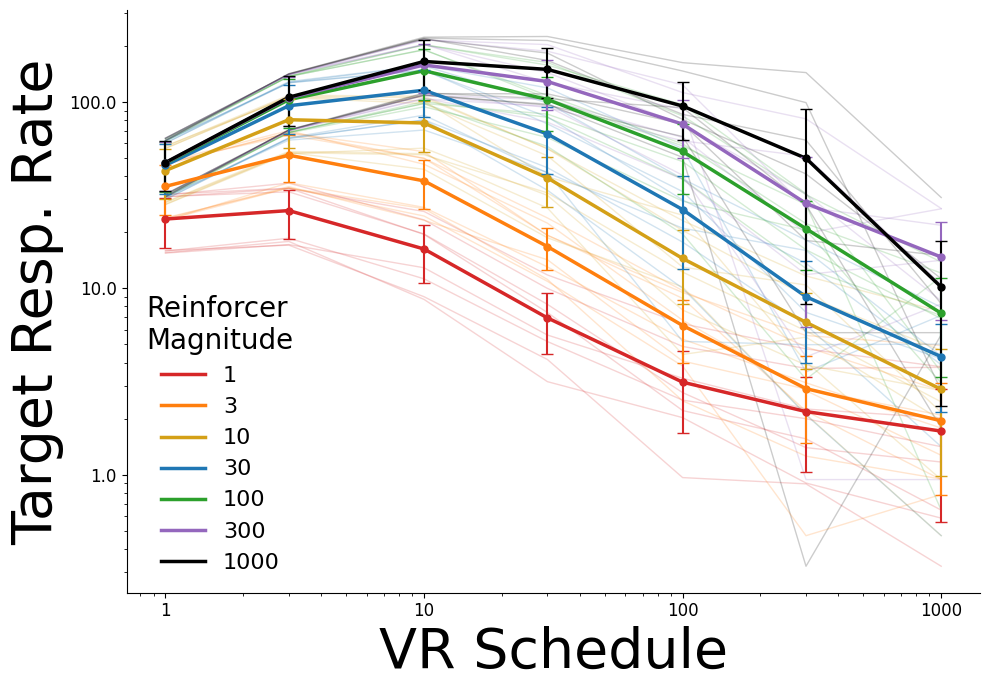

In [32]:
# Prepare data
results_df_sorted = results_df.sort_values(['AO_id', 'reinforcer_magnitude', 'VR'])
results_df_sorted['b_target_avg'] *= 60  # Convert to responses per minute

# Define colors
custom_colors = [
    "#d62728",  # red
    "#ff7f0e",  # orange
    "#d4a017",  # darker yellow
    "#1f77b4",  # blue
    "#2ca02c",  # green
    "#9467bd",  # purple
    "#000000"   # black
]
unique_mags = sorted(results_df_sorted['reinforcer_magnitude'].unique())
color_map = dict(zip(unique_mags, custom_colors))

# Calculate group means and 95% CI
summary_df = (
    results_df_sorted
    .groupby(['reinforcer_magnitude', 'VR'])['b_target_avg']
    .agg(['mean', sem])
    .reset_index()
    .rename(columns={'mean': 'b_target_avg_mean', 'sem': 'b_target_avg_se'})
)
summary_df['ci'] = summary_df['b_target_avg_se'] * t.ppf(0.975, df=len(results_df_sorted['AO_id'].unique()) - 1)

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 7))

# Plot each AO’s faint line by magnitude
for (ao_id, magnitude), group in results_df_sorted.groupby(['AO_id', 'reinforcer_magnitude']):
    ax.plot(
        group['VR'],
        group['b_target_avg'],
        color=color_map[magnitude],
        alpha=0.2,
        linewidth=1
    )

# Plot mean line per magnitude
sns.lineplot(
    data=summary_df,
    x='VR',
    y='b_target_avg_mean',
    hue='reinforcer_magnitude',
    palette=color_map,
    linewidth=2.5,
    ax=ax,
    legend=True
)

# Plot mean points with CI error bars
for mag in unique_mags:
    sub = summary_df[summary_df['reinforcer_magnitude'] == mag]
    ax.errorbar(
        x=sub['VR'],
        y=sub['b_target_avg_mean'],
        yerr=sub['ci'],
        fmt='o',
        color=color_map[mag],
        ecolor=color_map[mag],
        capsize=4,
        markersize=5,
        linestyle='none',
        label=None
    )

# --- Axes formatting ---
ax.set_xscale("log")
ax.set_yscale("log")
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))

# --- Labels, legend, and cleanup ---
ax.set_xlabel("VR Schedule", fontsize=40)
ax.set_ylabel("Target Resp. Rate", fontsize=40)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(title='Reinforcer\nMagnitude', title_fontsize=20, fontsize=16, loc='best', frameon=False)
sns.despine()
plt.tight_layout()
plt.show()

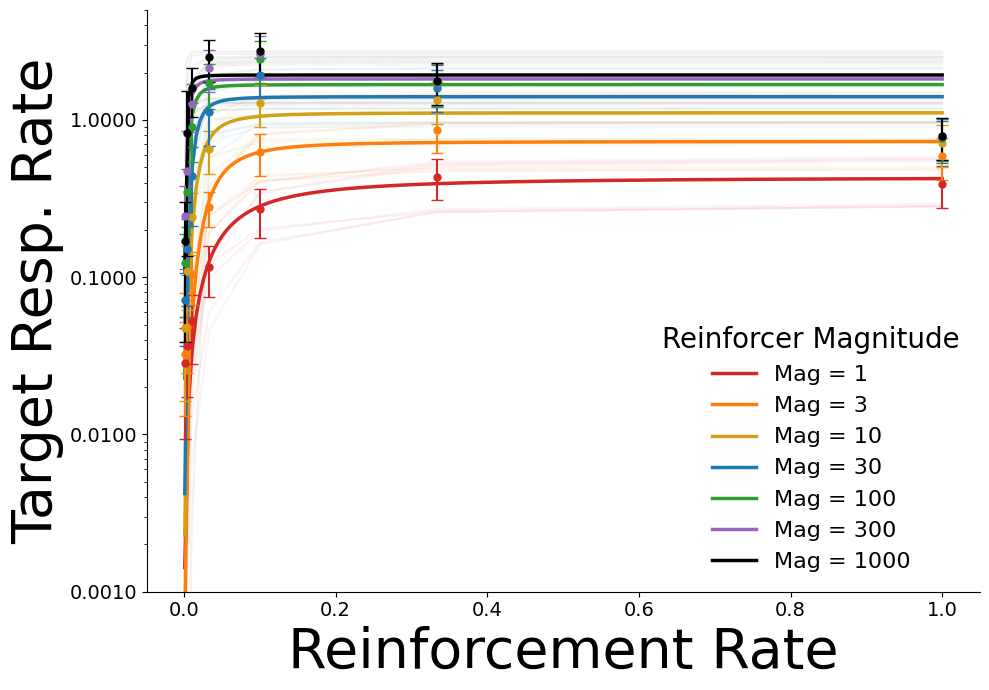

In [33]:
# --- Define the generalized hyperbola function ---
def generalized_hyperbola(r, a, b, c):
    return (b * (r ** a)) / (r ** a + c)

# --- Define color palette ---
color_palette = [
    "#d62728",  # red
    "#ff7f0e",  # orange
    "#d4a017",  # dark yellow
    "#1f77b4",  # blue
    "#2ca02c",  # green
    "#9467bd",  # purple
    "#000000"   # black
]

magnitudes_sorted = sorted(results_df['reinforcer_magnitude'].unique())
color_map = dict(zip(magnitudes_sorted, color_palette))

# --- Scale to responses per minute ---
results_df['b_target_avg'] * 60
results_df['r'] = 1 / results_df['VR']

# --- Fit group-level models ---
group_fits = []
curve_fits_by_mag = []

for mag in magnitudes_sorted:
    group = results_df[results_df['reinforcer_magnitude'] == mag]

    grouped = group.groupby('r').agg(
        b_target_avg_mean=('b_target_avg', 'mean'),
        b_target_avg_se=('b_target_avg', sem)
    ).reset_index()

    grouped['b_target_avg_ci'] = grouped['b_target_avg_se'] * t.ppf(0.975, df=len(group['AO_id'].unique()) - 1)

    try:
        popt, _ = curve_fit(
            generalized_hyperbola,
            grouped['r'],
            grouped['b_target_avg_mean'],
            p0=[1.0, 1.0, 0.1],
            bounds=(0, np.inf)
        )

        r_vals = np.linspace(grouped['r'].min(), grouped['r'].max(), 200)
        predicted = generalized_hyperbola(r_vals, *popt)

        residuals = grouped['b_target_avg_mean'] - generalized_hyperbola(grouped['r'], *popt)
        ss_res = np.sum(residuals ** 2)
        ss_tot = np.sum((grouped['b_target_avg_mean'] - np.mean(grouped['b_target_avg_mean'])) ** 2)
        r_squared = 1 - (ss_res / ss_tot)

        group_fits.append({
            'reinforcer_magnitude': mag,
            'a': popt[0],
            'b': popt[1],
            'c': popt[2],
            'r_squared': r_squared
        })

        curve_fits_by_mag.append(pd.DataFrame({
            'reinforcer_magnitude': mag,
            'r': r_vals,
            'predicted_b_target': predicted
        }))

    except Exception as e:
        print(f"Group-level fit failed for magnitude {mag}: {e}")

# --- Fit individual AO-level models and store results ---
individual_fits = []

plt.figure(figsize=(10, 7))

for (ao_id, mag), group in results_df.groupby(['AO_id', 'reinforcer_magnitude']):
    r_vals = 1 / group['VR']
    try:
        popt, _ = curve_fit(
            generalized_hyperbola,
            r_vals,
            group['b_target_avg'],
            p0=[1.0, 1.0, 0.1],
            bounds=(0, np.inf),
            maxfev=10000
        )
        pred = generalized_hyperbola(r_vals, *popt)
        plt.plot(r_vals, pred, alpha=0.05, color=color_map[mag])

        residuals = group['b_target_avg'] - pred
        ss_res = np.sum(residuals ** 2)
        ss_tot = np.sum((group['b_target_avg'] - np.mean(group['b_target_avg'])) ** 2)
        r_squared = 1 - (ss_res / ss_tot)

        individual_fits.append({
            'AO_id': ao_id,
            'reinforcer_magnitude': mag,
            'a': popt[0],
            'b': popt[1],
            'c': popt[2],
            'r_squared': r_squared
        })

    except Exception as e:
        print(f"AO-level fit failed for AO {ao_id}, mag {mag}: {e}")
        continue

# --- Convert individual fits to DataFrame ---
fit_df = pd.DataFrame(individual_fits)

# --- Combine group-level curve fits ---
curve_df = pd.concat(curve_fits_by_mag, ignore_index=True)

# --- Plot group-level fits ---
for mag, df in curve_df.groupby('reinforcer_magnitude'):
    plt.plot(
        df['r'],
        df['predicted_b_target'],
        color=color_map[mag],
        linewidth=2.5,
        label=f'Mag = {mag}'
    )

# --- Add mean ± CI error bars ---
for mag in magnitudes_sorted:
    group = results_df[results_df['reinforcer_magnitude'] == mag]
    grouped = group.groupby('r').agg(
        b_target_avg_mean=('b_target_avg', 'mean'),
        b_target_avg_se=('b_target_avg', sem)
    ).reset_index()

    grouped['b_target_avg_ci'] = grouped['b_target_avg_se'] * t.ppf(0.975, df=len(group['AO_id'].unique()) - 1)

    plt.errorbar(
        grouped['r'],
        grouped['b_target_avg_mean'],
        yerr=grouped['b_target_avg_ci'],
        fmt='o',
        color=color_map[mag],
        ecolor=color_map[mag],
        elinewidth=1.5,
        capsize=4,
        markersize=5,
        linestyle='none'
    )

# --- Plot formatting ---
plt.yscale("log")
plt.xlabel("Reinforcement Rate", fontsize=40)
plt.ylabel("Target Resp. Rate", fontsize=40)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0.001, 5)
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.4f'))
plt.legend(title='Reinforcer Magnitude', title_fontsize=20, fontsize=16, loc="best", frameon=False)
sns.despine()
plt.tight_layout()
plt.show()

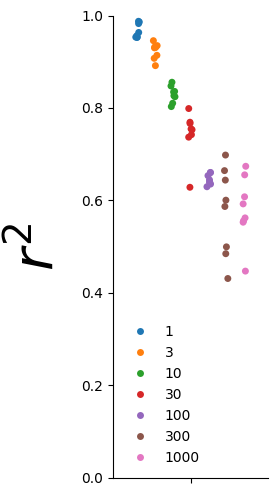

,count,mean,std,min,25%,50%,75%,max
reinforcer_magnitude,,,,,,,,
1,8.0,0.966803,0.015777,0.952376,0.953275,0.959779,0.983389,0.987456
3,8.0,0.923248,0.017583,0.891454,0.912233,0.930487,0.932712,0.945513
10,8.0,0.829566,0.017682,0.802833,0.820661,0.830384,0.838605,0.855545
30,8.0,0.743523,0.050373,0.628197,0.740702,0.753649,0.767014,0.798626
100,8.0,0.645026,0.011580,0.629346,0.637888,0.641707,0.654994,0.660317
300,8.0,0.575887,0.095113,0.430730,0.495519,0.593429,0.648839,0.697933
1000,8.0,0.580663,0.070449,0.446750,0.554817,0.577060,0.619446,0.673639


In [34]:
plot_df = fit_df.copy()
fig, ax = plt.subplots(figsize=(2, 6))
sns.stripplot(hue=plot_df['reinforcer_magnitude'].astype(str), y=plot_df['r_squared'], dodge=True)
sns.despine(top=True, right=True)
plt.ylabel(r"$r^2$", fontsize=40, labelpad=12)
plt.ylim(0, 1)
plt.legend(frameon=False, title="")
plt.show()
fit_df.groupby('reinforcer_magnitude')['r_squared'].describe()

In [35]:
# --- MPR Model Equations ---
def update_arousal(prev_arousal: float, reinforcement: int, alpha: float, a: float) -> float:
    return alpha * (a * reinforcement) + (1 - alpha) * prev_arousal

def compute_total_response_rate(A: float, delta: float) -> float:
    return (1 / delta) * (A / (1 + A))

def compute_target_response_rate(A: float, delta: float, coupling: float) -> float:
    return coupling * (1 / delta) * (A / (1 + A))

def compute_c_star_vi(reinforcement_rate, rho=0.6, k=1.0, epsilon=0.8):
    """Compute schedule-sensitive coupling for VI."""
    return rho * (reinforcement_rate / (reinforcement_rate + k)) * epsilon

def update_coupling(prev_coupling: float, c_star: float, learning_rate: float):
    """Recursive update toward asymptotic coupling C*."""
    return prev_coupling + learning_rate * (c_star - prev_coupling)

def update_step(prev_arousal, prev_coupling, reinforcement, a, delta, alpha, eta,
                reinforcement_rate, rho=0.6, k=1.0, epsilon=0.8):
    A = update_arousal(prev_arousal, reinforcement, alpha, a)
    C_star = compute_c_star_vi(reinforcement_rate, rho, k, epsilon)
    C = update_coupling(prev_coupling, C_star, learning_rate=eta)
    b_total = compute_total_response_rate(A, delta)
    b_target = compute_target_response_rate(A, delta, C)
    return A, C, b_total, b_target

def ci95(data):
    n = len(data)
    return sem(data) * t.ppf(0.975, n - 1)

# --- AO Simulation for Sequential VI Schedules ---
def simulate_mpr_vi_sequence(vi_schedule_list, a, delta, alpha, eta, ao_id,
                             steps_per_schedule=1000, avg_peck_rate=2.5,
                             rho=0.6, k=1.0, epsilon=0.8):
    A, C = 0.6, 0.5
    all_results = []

    for vi_idx, vi_sec in enumerate(vi_schedule_list):
        A_hist, C_hist, bt_hist, bp_hist = [], [], [], []
        reinforcement_history = []

        avg_irt = 1.0 / avg_peck_rate
        vi_times = np.cumsum(np.random.exponential(scale=vi_sec, size=steps_per_schedule))
        current_time = 0
        next_reinforcement_time = vi_times[0]
        vi_index = 0

        for _ in range(steps_per_schedule):
            current_time += avg_irt
            reinforcement = 0
            if current_time >= next_reinforcement_time:
                reinforcement = 1
                vi_index += 1
                if vi_index < len(vi_times):
                    next_reinforcement_time = vi_times[vi_index]

            reinforcement_history.append(reinforcement)

            # Compute reinforcement rate using last 50 responses
            recent = reinforcement_history[-50:]
            reinforcement_rate = sum(recent) / (len(recent) * avg_irt)  # reinf/sec

            A, C, b_total, b_target = update_step(
                A, C, reinforcement, a, delta, alpha, eta,
                reinforcement_rate=reinforcement_rate,
                rho=rho, k=k, epsilon=epsilon
            )
            A_hist.append(A)
            C_hist.append(C)
            bt_hist.append(b_total)
            bp_hist.append(b_target)

        all_results.append({
            'AO_id': ao_id,
            'vi_sequence_index': vi_idx,
            'VI': vi_sec,
            'arousal_avg': np.mean(A_hist),
            'arousal_min': np.min(A_hist),
            'arousal_max': np.max(A_hist),
            'arousal_ci': ci95(A_hist),
            'coupling_avg': np.mean(C_hist),
            'coupling_min': np.min(C_hist),
            'coupling_max': np.max(C_hist),
            'coupling_ci': ci95(C_hist),
            'b_total_avg': np.mean(bt_hist),
            'b_total_min': np.min(bt_hist),
            'b_total_max': np.max(bt_hist),
            'b_total_ci': ci95(bt_hist),
            'b_target_avg': np.mean(bp_hist),
            'b_target_min': np.min(bp_hist),
            'b_target_max': np.max(bp_hist),
            'b_target_ci': ci95(bp_hist),
            'reinforcer_magnitude': a,
            'delta': delta,
            'alpha': alpha,
            'eta': eta,
        })

    return all_results

# Parameters
deltas = [0.25, 0.50, 1.0, 2.0]
reinforcer_magnitudes = [1, 3, 10, 30, 100, 300, 1000]
alphas = [0.01, 0.03, 0.1, 0.3, 1.0]
etas = [0.01, 0.03, 0.3, 1.0]
vi_schedules = [1, 3, 10, 30, 100, 300, 1000]

# Run each AO across all VI schedules in random order
results_vi = []
grid = list(product(reinforcer_magnitudes, deltas, alphas, etas))

for ao_id, (a, delta, alpha, eta) in enumerate(tqdm(grid, desc="Running AO simulations through VI schedules")):
    shuffled_vis = np.random.permutation(vi_schedules)
    sim_result_list = simulate_mpr_vi_sequence(shuffled_vis, a, delta, alpha, eta, ao_id=ao_id)
    results_vi.extend(sim_result_list)

# Final DataFrame
results_vi_df = pd.DataFrame(results_vi)
results_vi_df['b_target_avg'] = results_vi_df['b_target_avg'] * 60  # Convert to responses/min

Running AO simulations through VI schedules: 100%|██████████| 560/560 [00:19<00:00, 29.25it/s]


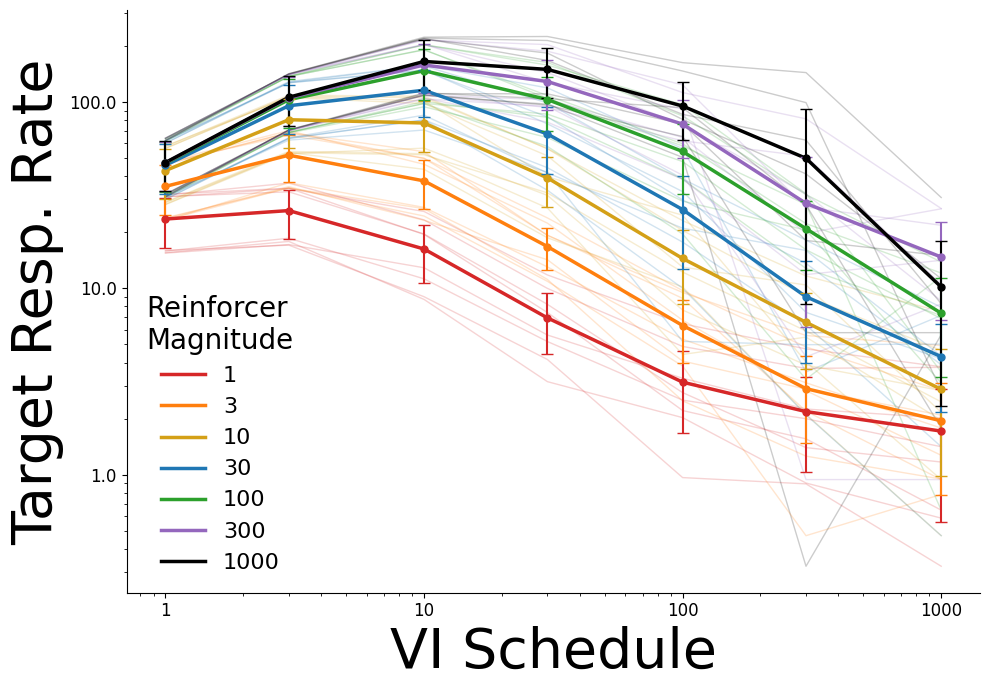

In [36]:
# Prepare data
results_df_sorted = results_df.sort_values(['AO_id', 'reinforcer_magnitude', 'VR'])
results_df_sorted['b_target_avg'] *= 60  # Convert to responses per minute

# Define colors
custom_colors = [
    "#d62728",  # red
    "#ff7f0e",  # orange
    "#d4a017",  # darker yellow
    "#1f77b4",  # blue
    "#2ca02c",  # green
    "#9467bd",  # purple
    "#000000"   # black
]
unique_mags = sorted(results_df_sorted['reinforcer_magnitude'].unique())
color_map = dict(zip(unique_mags, custom_colors))

# Calculate group means and 95% CI
summary_df = (
    results_df_sorted
    .groupby(['reinforcer_magnitude', 'VR'])['b_target_avg']
    .agg(['mean', sem])
    .reset_index()
    .rename(columns={'mean': 'b_target_avg_mean', 'sem': 'b_target_avg_se'})
)
summary_df['ci'] = summary_df['b_target_avg_se'] * t.ppf(0.975, df=len(results_df_sorted['AO_id'].unique()) - 1)

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 7))

# Plot each AO’s faint line by magnitude
for (ao_id, magnitude), group in results_df_sorted.groupby(['AO_id', 'reinforcer_magnitude']):
    ax.plot(
        group['VR'],
        group['b_target_avg'],
        color=color_map[magnitude],
        alpha=0.2,
        linewidth=1
    )

# Plot mean line per magnitude
sns.lineplot(
    data=summary_df,
    x='VR',
    y='b_target_avg_mean',
    hue='reinforcer_magnitude',
    palette=color_map,
    linewidth=2.5,
    ax=ax,
    legend=True
)

# Plot mean points with CI error bars
for mag in unique_mags:
    sub = summary_df[summary_df['reinforcer_magnitude'] == mag]
    ax.errorbar(
        x=sub['VR'],
        y=sub['b_target_avg_mean'],
        yerr=sub['ci'],
        fmt='o',
        color=color_map[mag],
        ecolor=color_map[mag],
        capsize=4,
        markersize=5,
        linestyle='none',
        label=None
    )

# --- Axes formatting ---
ax.set_xscale("log")
ax.set_yscale("log")
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))

# --- Labels, legend, and cleanup ---
ax.set_xlabel("VI Schedule", fontsize=40)
ax.set_ylabel("Target Resp. Rate", fontsize=40)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(title='Reinforcer\nMagnitude', title_fontsize=20, fontsize=16, loc='best', frameon=False)
sns.despine()
plt.tight_layout()
plt.show()

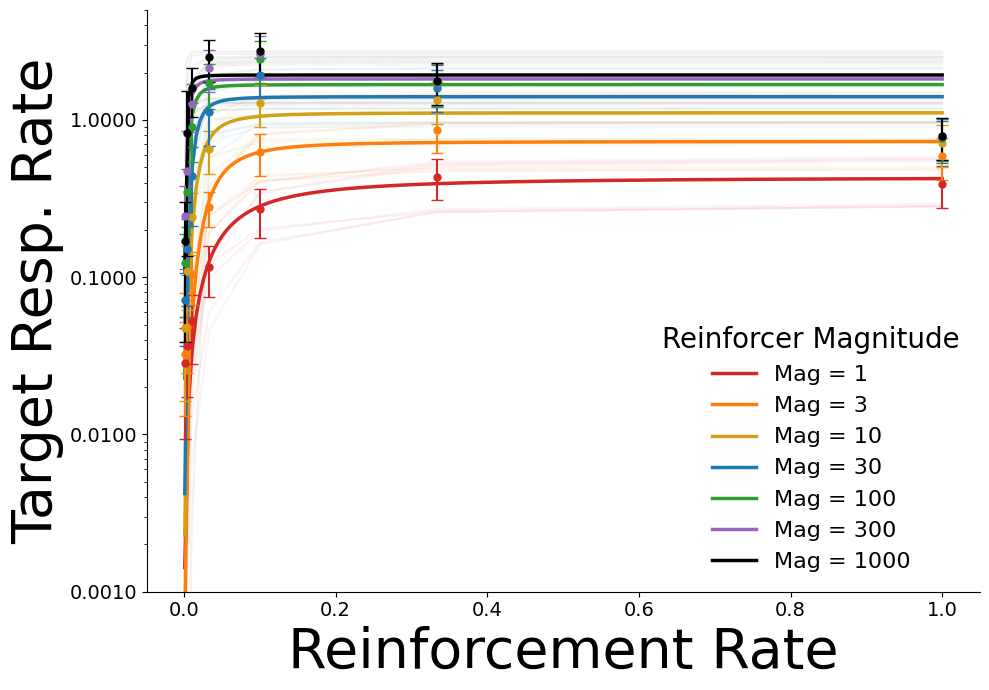

In [37]:
# --- Define the generalized hyperbola function ---
def generalized_hyperbola(r, a, b, c):
    return (b * (r ** a)) / (r ** a + c)

# --- Define color palette ---
color_palette = [
    "#d62728",  # red
    "#ff7f0e",  # orange
    "#d4a017",  # dark yellow
    "#1f77b4",  # blue
    "#2ca02c",  # green
    "#9467bd",  # purple
    "#000000"   # black
]

magnitudes_sorted = sorted(results_df['reinforcer_magnitude'].unique())
color_map = dict(zip(magnitudes_sorted, color_palette))

# --- Scale to responses per minute ---
results_df['b_target_avg'] * 60
results_df['r'] = 1 / results_df['VR']

# --- Fit group-level models ---
group_fits = []
curve_fits_by_mag = []

for mag in magnitudes_sorted:
    group = results_df[results_df['reinforcer_magnitude'] == mag]

    grouped = group.groupby('r').agg(
        b_target_avg_mean=('b_target_avg', 'mean'),
        b_target_avg_se=('b_target_avg', sem)
    ).reset_index()

    grouped['b_target_avg_ci'] = grouped['b_target_avg_se'] * t.ppf(0.975, df=len(group['AO_id'].unique()) - 1)

    try:
        popt, _ = curve_fit(
            generalized_hyperbola,
            grouped['r'],
            grouped['b_target_avg_mean'],
            p0=[1.0, 1.0, 0.1],
            bounds=(0, np.inf)
        )

        r_vals = np.linspace(grouped['r'].min(), grouped['r'].max(), 200)
        predicted = generalized_hyperbola(r_vals, *popt)

        residuals = grouped['b_target_avg_mean'] - generalized_hyperbola(grouped['r'], *popt)
        ss_res = np.sum(residuals ** 2)
        ss_tot = np.sum((grouped['b_target_avg_mean'] - np.mean(grouped['b_target_avg_mean'])) ** 2)
        r_squared = 1 - (ss_res / ss_tot)

        group_fits.append({
            'reinforcer_magnitude': mag,
            'a': popt[0],
            'b': popt[1],
            'c': popt[2],
            'r_squared': r_squared
        })

        curve_fits_by_mag.append(pd.DataFrame({
            'reinforcer_magnitude': mag,
            'r': r_vals,
            'predicted_b_target': predicted
        }))

    except Exception as e:
        print(f"Group-level fit failed for magnitude {mag}: {e}")

# --- Fit individual AO-level models and store results ---
individual_fits = []

plt.figure(figsize=(10, 7))

for (ao_id, mag), group in results_df.groupby(['AO_id', 'reinforcer_magnitude']):
    r_vals = 1 / group['VR']
    try:
        popt, _ = curve_fit(
            generalized_hyperbola,
            r_vals,
            group['b_target_avg'],
            p0=[1.0, 1.0, 0.1],
            bounds=(0, np.inf),
            maxfev=10000
        )
        pred = generalized_hyperbola(r_vals, *popt)
        plt.plot(r_vals, pred, alpha=0.05, color=color_map[mag])

        residuals = group['b_target_avg'] - pred
        ss_res = np.sum(residuals ** 2)
        ss_tot = np.sum((group['b_target_avg'] - np.mean(group['b_target_avg'])) ** 2)
        r_squared = 1 - (ss_res / ss_tot)

        individual_fits.append({
            'AO_id': ao_id,
            'reinforcer_magnitude': mag,
            'a': popt[0],
            'b': popt[1],
            'c': popt[2],
            'r_squared': r_squared
        })

    except Exception as e:
        print(f"AO-level fit failed for AO {ao_id}, mag {mag}: {e}")
        continue

# --- Convert individual fits to DataFrame ---
fit_df = pd.DataFrame(individual_fits)

# --- Combine group-level curve fits ---
curve_df = pd.concat(curve_fits_by_mag, ignore_index=True)

# --- Plot group-level fits ---
for mag, df in curve_df.groupby('reinforcer_magnitude'):
    plt.plot(
        df['r'],
        df['predicted_b_target'],
        color=color_map[mag],
        linewidth=2.5,
        label=f'Mag = {mag}'
    )

# --- Add mean ± CI error bars ---
for mag in magnitudes_sorted:
    group = results_df[results_df['reinforcer_magnitude'] == mag]
    grouped = group.groupby('r').agg(
        b_target_avg_mean=('b_target_avg', 'mean'),
        b_target_avg_se=('b_target_avg', sem)
    ).reset_index()

    grouped['b_target_avg_ci'] = grouped['b_target_avg_se'] * t.ppf(0.975, df=len(group['AO_id'].unique()) - 1)

    plt.errorbar(
        grouped['r'],
        grouped['b_target_avg_mean'],
        yerr=grouped['b_target_avg_ci'],
        fmt='o',
        color=color_map[mag],
        ecolor=color_map[mag],
        elinewidth=1.5,
        capsize=4,
        markersize=5,
        linestyle='none'
    )

# --- Plot formatting ---
plt.yscale("log")
plt.xlabel("Reinforcement Rate", fontsize=40)
plt.ylabel("Target Resp. Rate", fontsize=40)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0.001, 5)
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.4f'))
plt.legend(title='Reinforcer Magnitude', title_fontsize=20, fontsize=16, loc="best", frameon=False)
sns.despine()
plt.tight_layout()
plt.show()

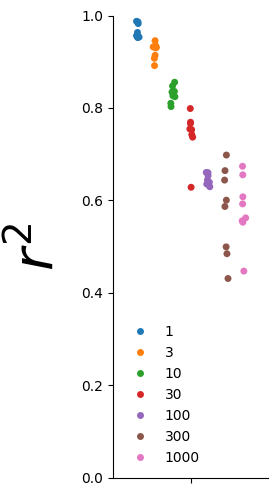

,count,mean,std,min,25%,50%,75%,max
reinforcer_magnitude,,,,,,,,
1,8.0,0.966803,0.015777,0.952376,0.953275,0.959779,0.983389,0.987456
3,8.0,0.923248,0.017583,0.891454,0.912233,0.930487,0.932712,0.945513
10,8.0,0.829566,0.017682,0.802833,0.820661,0.830384,0.838605,0.855545
30,8.0,0.743523,0.050373,0.628197,0.740702,0.753649,0.767014,0.798626
100,8.0,0.645026,0.011580,0.629346,0.637888,0.641707,0.654994,0.660317
300,8.0,0.575887,0.095113,0.430730,0.495519,0.593429,0.648839,0.697933
1000,8.0,0.580663,0.070449,0.446750,0.554817,0.577060,0.619446,0.673639


In [38]:
plot_df = fit_df.copy()
fig, ax = plt.subplots(figsize=(2, 6))
sns.stripplot(hue=plot_df['reinforcer_magnitude'].astype(str), y=plot_df['r_squared'], dodge=True)
sns.despine(top=True, right=True)
plt.ylabel(r"$r^2$", fontsize=40, labelpad=12)
plt.ylim(0, 1)
plt.legend(frameon=False, title="")
plt.show()
fit_df.groupby('reinforcer_magnitude')['r_squared'].describe()

## Concurrent VR Magnitude Manipulation

In [59]:
# --- MPR Model Equations ---
def update_arousal(prev_arousal: float, reinforcement: int, alpha: float, a: float) -> float:
    return alpha * (a * reinforcement) + (1 - alpha) * prev_arousal

def compute_total_response_rate(A: float, delta: float) -> float:
    return (1 / delta) * (A / (1 + A))

def compute_target_response_rate(A: float, delta: float, coupling: float) -> float:
    return coupling * (1 / delta) * (A / (1 + A))

import math

def compute_c_star_vr(vr_value, lambda_=0.3):
    """Compute coupling asymptote for VR schedule."""
    return 1 - math.exp(-lambda_ * vr_value)

def update_coupling(prev_coupling: float, c_star: float, learning_rate: float) -> float:
    """Update toward coupling asymptote C*."""
    return prev_coupling + learning_rate * (c_star - prev_coupling)

def update_step(prev_arousal, prev_coupling, reinforcement, a, delta, alpha, eta,
                schedule_param, lambda_=0.3):
    A = update_arousal(prev_arousal, reinforcement, alpha, a)
    C_star = compute_c_star_vr(schedule_param, lambda_)
    C = update_coupling(prev_coupling, C_star, eta)
    b_total = compute_total_response_rate(A, delta)
    b_target = compute_target_response_rate(A, delta, C)
    return A, C, b_total, b_target

# --- CI Helper ---
def ci95(data):
    n = len(data)
    return sem(data) * t.ppf(0.975, n - 1)

# --- Simulation with Persistent State Across Concurrent VR Pairs ---
def simulate_concurrent_mpr_sequence(vr_pairs, magnitudes, a, delta, alpha, eta, ao_id,
                                     num_steps=1000, cod_duration=3, lambda_=0.3):
    A1, C1 = 0.6, 0.5
    A2, C2 = 0.6, 0.5
    all_results = []

    for pair_index, ((vr1, vr2), (mag1, mag2)) in enumerate(zip(vr_pairs, magnitudes)):
        A1_hist, A2_hist = [], []
        C1_hist, C2_hist = [], []
        b1_hist, b2_hist = [], []

        last_choice = None
        cod_counter = 0

        for _ in range(num_steps):
            # Softmax-style choice rule
            denom = C1 + C2
            p1 = C1 / denom if denom > 0 else 0.5
            choice = np.random.choice([1, 2], p=[p1, 1 - p1])

            # Determine if switched (for CoD)
            switched = (last_choice is not None) and (choice != last_choice)
            last_choice = choice

            # Handle CoD
            if switched:
                cod_counter = cod_duration
            cod_counter = max(cod_counter - 1, 0)

            # Reinforcement logic
            r1 = int(np.random.rand() < (1 / vr1))*mag1 if cod_counter == 0 and choice == 1 else 0
            r2 = int(np.random.rand() < (1 / vr2))*mag2 if cod_counter == 0 and choice == 2 else 0

            if choice == 1:
                A1, C1, _, _ = update_step(A1, C1, r1, a, delta, alpha, eta, vr1, lambda_)
                A2 = update_arousal(A2, 0, alpha, a)
                C2_star = compute_c_star_vr(vr2, lambda_)
                C2 = update_coupling(C2, C2_star, eta)
            else:
                A2, C2, _, _ = update_step(A2, C2, r2, a, delta, alpha, eta, vr2, lambda_)
                A1 = update_arousal(A1, 0, alpha, a)
                C1_star = compute_c_star_vr(vr1, lambda_)
                C1 = update_coupling(C1, C1_star, eta)

            A1_hist.append(A1)
            A2_hist.append(A2)
            C1_hist.append(C1)
            C2_hist.append(C2)
            b1_hist.append(1 if choice == 1 else 0)
            b2_hist.append(1 if choice == 2 else 0)

        all_results.append({
            'AO_id': ao_id,
            'pair_index': pair_index,
            'VR1': vr1,
            'VR2': vr2,
            'magnitude1': mag1,
            'magnitude2': mag2,
            'magnitude_ratio': np.round((mag2 / mag1), 2),
            'reinforcement_ratio': np.round((vr2 / vr1), 2),
            'arousal1_avg': np.mean(A1_hist),
            'arousal2_avg': np.mean(A2_hist),
            'coupling1_avg': np.mean(C1_hist),
            'coupling2_avg': np.mean(C2_hist),
            'choice1_avg': np.mean(b1_hist),
            'choice2_avg': np.mean(b2_hist),
            'arousal1_ci': ci95(A1_hist),
            'arousal2_ci': ci95(A2_hist),
            'coupling1_ci': ci95(C1_hist),
            'coupling2_ci': ci95(C2_hist),
            'choice1_ci': ci95(b1_hist),
            'choice2_ci': ci95(b2_hist),
            'activation': a,
            'delta': delta,
            'alpha': alpha,
            'eta': eta
        })

    return all_results

# Parameter Grid
deltas = [0.25, 0.50, 1.0, 2.0]
activations = [0.1, 0.2, 0.4, 0.8, 1.6]
alphas = [0.01, 0.03, 0.1, 0.3, 1.0]
etas = [0.01, 0.03, 0.3, 1.0]
vr_pairs = [(1, 9), (1, 3), (2, 2), (3, 1), (9, 1)]  # all pairs to be run per AO
magnitude_pairs = [(1, 3), (1, 10), (3, 10), (3, 1), (10, 1), (10, 3)]

# Create all combinations of VR pairs and magnitude pairs
all_combinations = list(product(vr_pairs, magnitude_pairs))

# Run each AO through all combinations
concurrent_results = []
grid = list(product(activations, deltas, alphas, etas))

for ao_id, (a, delta, alpha, eta) in enumerate(tqdm(grid, desc="Running concurrent VR AOs")):
    sim_result_list = simulate_concurrent_mpr_sequence(
        [pair[0] for pair in all_combinations],  # VR pairs
        [pair[1] for pair in all_combinations],  # Magnitude pairs
        a, delta, alpha, eta, ao_id=ao_id
    )
    concurrent_results.extend(sim_result_list)

# Convert to a df
results_concurrent_df = pd.DataFrame(concurrent_results)

Running concurrent VR AOs: 100%|██████████| 400/400 [05:29<00:00,  1.21it/s]


In [60]:
results_concurrent_df.sample(5)

,AO_id,pair_index,VR1,VR2,magnitude1,magnitude2,magnitude_ratio,reinforcement_ratio,arousal1_avg,arousal2_avg,coupling1_avg,coupling2_avg,choice1_avg,choice2_avg,arousal1_ci,arousal2_ci,coupling1_ci,coupling2_ci,choice1_ci,choice2_ci,activation,delta,alpha,eta
8292,276,12,2,2,1,3,3.0,1.00,0.050400,0.170400,0.432181,0.465270,0.470,0.530,0.012068,0.038268,2.367759e-03,1.754079e-03,0.030987,0.030987,0.8,0.50,1.00,0.01
4170,139,0,1,9,1,3,3.0,9.00,0.001400,0.036600,0.259182,0.932794,0.198,0.802,0.001035,0.008915,6.892901e-18,3.446451e-17,0.024741,0.024741,0.2,1.00,1.00,1.00
4859,161,29,9,1,10,3,0.3,0.11,0.215568,0.008102,0.932794,0.259182,0.792,0.208,0.003978,0.000383,2.067870e-17,3.446451e-18,0.025199,0.025199,0.4,0.25,0.01,0.03
617,20,17,2,2,10,3,0.3,1.00,0.051472,0.018387,0.451188,0.451188,0.507,0.493,0.000693,0.000396,6.892901e-18,6.892901e-18,0.031040,0.031040,0.1,0.50,0.01,0.01
853,28,13,2,2,1,10,10.0,1.00,0.006050,0.049275,0.451188,0.451189,0.514,0.486,0.000389,0.003508,1.022191e-07,7.572578e-08,0.031031,0.031031,0.1,0.50,0.10,0.01


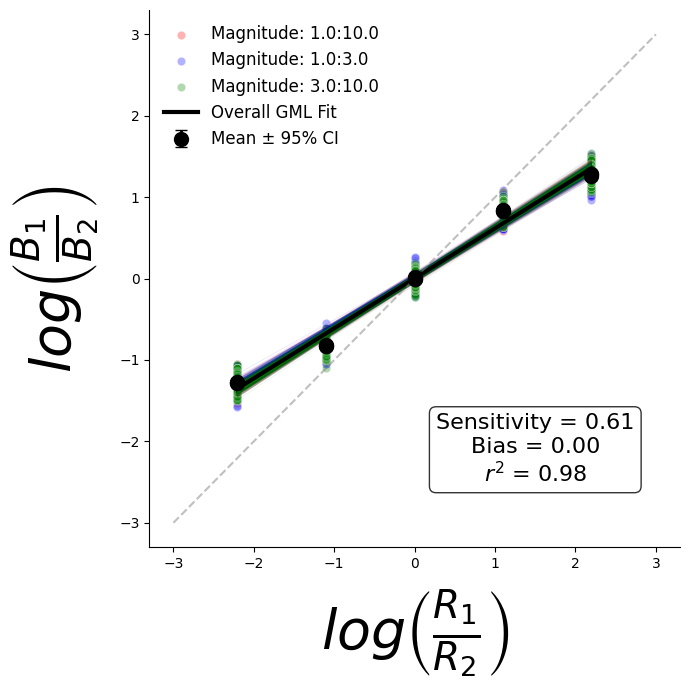

Individual AO fits summary:
Number of AOs with valid fits: 1200
Mean sensitivity across AOs: 0.614 ± 0.016
Mean bias across AOs: 0.004 ± 0.023
Mean R² across AOs: 0.983 ± 0.006


In [61]:
# Prep data
results_concurrent_df['response_ratio'] = results_concurrent_df['choice2_avg'] / results_concurrent_df['choice1_avg']
results_concurrent_df['log_resp_ratio'] = np.log(results_concurrent_df['response_ratio'])
results_concurrent_df['log_reinf_ratio'] = np.log(results_concurrent_df['reinforcement_ratio'])


# Create normalized magnitude labels (always smaller:larger)
def normalize_magnitude_label(row):
    if row['magnitude1'] <= row['magnitude2']:
        return f"{row['magnitude1']}:{row['magnitude2']}"
    else:
        return f"{row['magnitude2']}:{row['magnitude1']}"

results_concurrent_df['magnitude_label'] = results_concurrent_df.apply(normalize_magnitude_label, axis=1)

# Fit GML to each AO within each magnitude label
ao_fits = []
ao_lines = []

for (ao_id, mag_label), group in results_concurrent_df.groupby(["AO_id", "magnitude_label"]):
    if group['log_reinf_ratio'].nunique() < 2:
        continue
    
    X = group[['log_reinf_ratio']]
    y = group['log_resp_ratio']
    model = LinearRegression().fit(X, y)
    
    ao_fits.append({
        'AO_id': ao_id,
        'magnitude_label': mag_label,
        'sensitivity': model.coef_[0],  # 'a' parameter
        'bias': model.intercept_,       # log(c) parameter
        'r_squared': r2_score(y, model.predict(X))
    })
    
    # Store line for plotting
    x_range = np.linspace(X.min(), X.max(), 100)
    ao_lines.append(pd.DataFrame({
        'AO_id': ao_id,
        'magnitude_label': mag_label,
        'x': x_range.squeeze(),
        'y': model.predict(pd.DataFrame({'log_reinf_ratio': x_range.squeeze()}))
    }))

# Convert to DataFrames
fit_df = pd.DataFrame(ao_fits)
ao_lines_df = pd.concat(ao_lines)

# Aggregate means across AOs per VR pair (not magnitude label) for overall fit
grouped_means = results_concurrent_df.groupby(['magnitude_label', 'reinforcement_ratio']).agg(
    log_resp_ratio_mean=('log_resp_ratio', 'mean'),
    log_resp_ratio_se=('log_resp_ratio', sem),
    log_reinf_ratio=('log_reinf_ratio', 'mean')
).reset_index()

grouped_means['log_resp_ratio_ci'] = grouped_means['log_resp_ratio_se'] * t.ppf(0.975, df=len(results_concurrent_df) - 1)

# Fit overall group-level GML using VR pairs (should be 5 data points)
X_group = results_concurrent_df[['log_reinf_ratio']]
y_group = results_concurrent_df['log_resp_ratio']

group_model = LinearRegression().fit(X_group, y_group)
group_sensitivity = group_model.coef_[0]
group_bias = group_model.intercept_
group_r2 = r2_score(y_group, group_model.predict(X_group))

x_range_group = np.linspace(X_group.min(), X_group.max(), 100)
y_pred_group = group_model.predict(pd.DataFrame({'log_reinf_ratio': x_range_group.squeeze()}))

# Plot everything
plt.figure(figsize=(7, 7))

# Define colors for different magnitude ratios
magnitude_labels = sorted(results_concurrent_df['magnitude_label'].unique())
colors = ['red', 'blue', 'green']
color_map = dict(zip(magnitude_labels, colors))

# Plot individual AOs by magnitude ratio
for mag_label in magnitude_labels:
    subset = results_concurrent_df[results_concurrent_df['magnitude_label'] == mag_label]
    sns.scatterplot(
        x='log_reinf_ratio',
        y='log_resp_ratio',
        data=subset,
        color=color_map[mag_label],
        alpha=0.3,
        label=f'Magnitude: {mag_label}', 
    )

# Plot individual AO fits by magnitude ratio
for mag_label in magnitude_labels:
    mag_lines = ao_lines_df[ao_lines_df['magnitude_label'] == mag_label]
    for ao_id, ao_line in mag_lines.groupby('AO_id'):
        plt.plot(ao_line['x'], ao_line['y'], color=color_map[mag_label], alpha=0.1, linewidth=0.5)

# Plot mean ± 95% CI for each VR pair (overall fit)
plt.errorbar(
    x=grouped_means['log_reinf_ratio'],
    y=grouped_means['log_resp_ratio_mean'],
    yerr=grouped_means['log_resp_ratio_ci'],
    fmt='o',
    color='black',
    markersize=10,
    elinewidth=2,
    capsize=4,
    markeredgecolor='black',
    label='Mean ± 95% CI'
)

# Plot overall group fit
plt.plot(x_range_group, y_pred_group, color='black', linewidth=3, label='Overall GML Fit')

# Identity line
plt.plot([-3, 3], [-3, 3], linestyle='--', color='gray', alpha=0.5)

# Labels and annotation
plt.xlabel(r'$\mathit{log}\left(\frac{R_1}{R_2}\right)$', fontsize=40, labelpad=12)
plt.ylabel(r'$\mathit{log}\left(\frac{B_1}{B_2}\right)$', fontsize=40, labelpad=12)

plt.text(
    1.5, -2.5,
    f"Sensitivity = {group_sensitivity:.2f}\nBias = {group_bias:.2f}\n$r^2$ = {group_r2:.2f}",
    fontsize=16,
    ha='center',
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8)
)

plt.legend(frameon=False, fontsize=12, loc='upper left')
sns.despine(top=True, right=True)
plt.grid(False)
plt.tight_layout()
plt.show()

# Display summary of individual AO fits
print(f"Individual AO fits summary:")
print(f"Number of AOs with valid fits: {len(fit_df)}")
print(f"Mean sensitivity across AOs: {fit_df['sensitivity'].mean():.3f} ± {fit_df['sensitivity'].std():.3f}")
print(f"Mean bias across AOs: {fit_df['bias'].mean():.3f} ± {fit_df['bias'].std():.3f}")
print(f"Mean R² across AOs: {fit_df['r_squared'].mean():.3f} ± {fit_df['r_squared'].std():.3f}")

In [62]:
fit_df

,AO_id,magnitude_label,sensitivity,bias,r_squared
0,0,1.0:10.0,0.607557,-0.055029,0.984582
1,0,1.0:3.0,0.587490,-0.019440,0.989178
2,0,3.0:10.0,0.623136,0.019276,0.978908
3,1,1.0:10.0,0.610401,0.019042,0.982853
4,1,1.0:3.0,0.593255,-0.040623,0.983991
...,...,...,...,...,...
1195,398,1.0:3.0,0.628705,0.036519,0.989780
1196,398,3.0:10.0,0.634965,0.020524,0.983311
1197,399,1.0:10.0,0.623358,0.010457,0.978147
1198,399,1.0:3.0,0.606903,-0.016917,0.973444


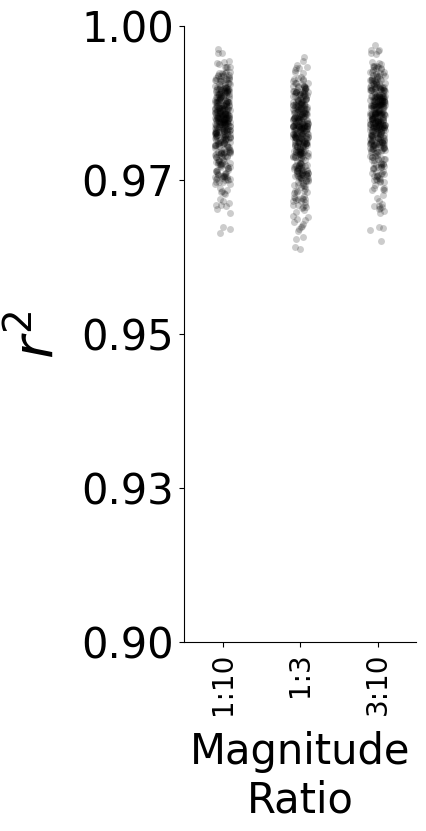

count    1200.000000
mean        0.983294
std         0.005767
min         0.963798
25%         0.979774
50%         0.983925
75%         0.987360
max         0.996873
Name: r_squared, dtype: float64

In [63]:
fig, ax = plt.subplots(figsize=(3, 8))
sns.stripplot(y=fit_df['r_squared'], x=fit_df['magnitude_label'], alpha=0.2, color='k')
sns.despine(top=True, right=True)
plt.ylabel(r"$r^2$", fontsize=40, labelpad=12)
plt.yticks(ticks=[0.9, 0.925, 0.95, 0.975, 1.0], fontsize=30)
ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
plt.xlabel("Magnitude\nRatio", fontsize=30, labelpad=12)
labels= ['1:10', '1:3', '3:10']
plt.xticks(ticks=[0, 1, 2], labels=labels, fontsize=20, rotation=90)
# plt.ylim(0.8, 1)
plt.show()
fit_df['r_squared'].describe()

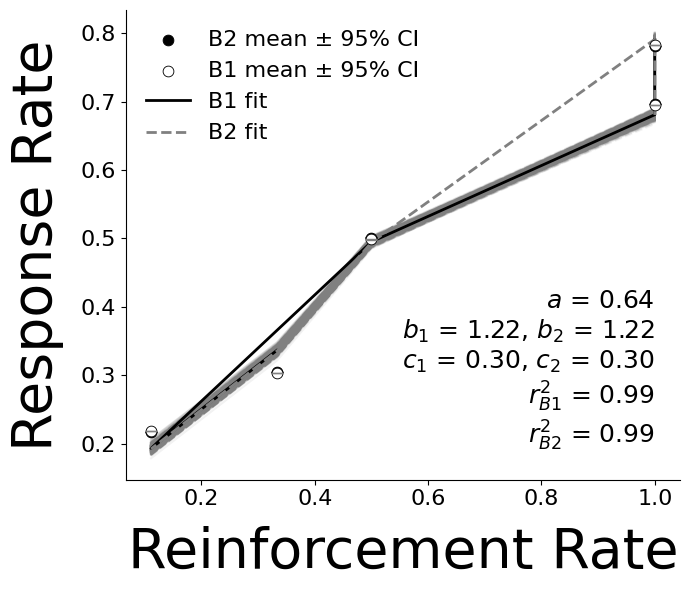

In [44]:
# Define McDowell concurrent schedule equations
def B1_eq(r1, r2, a, b1, c1, c2):
    return (b1 * (r1 ** a)) / (r1 ** a + (c1 / c2) * (r2 ** a) + c1)

def B2_eq(r1, r2, a, b2, c1, c2):
    return (b2 * (r2 ** a)) / ((c2 / c1) * (r1 ** a) + (r2 ** a) + c2)

# Joint residual function for least squares
def joint_residuals(params, r1, r2, B1_obs, B2_obs):
    a, b1, b2, c1, c2 = params
    B1_pred = B1_eq(r1, r2, a, b1, c1, c2)
    B2_pred = B2_eq(r1, r2, a, b2, c1, c2)
    return np.concatenate([(B1_pred - B1_obs), (B2_pred - B2_obs)])

# Prepare data
results_df = results_concurrent_df.copy()
results_df['r1'] = 1 / results_df['VR1']
results_df['r2'] = 1 / results_df['VR2']

# Fit per AO
fit_results = []
ao_fits = []

for ao_id, group in results_df.groupby("AO_id"):
    if group.shape[0] < 5:
        continue
    try:
        x0 = [1.0, 1.0, 1.0, 0.1, 0.1]
        res = least_squares(
            joint_residuals,
            x0=x0,
            bounds=(0, np.inf),
            args=(group['r1'].values, group['r2'].values, group['choice2_avg'].values, group['choice1_avg'].values)
        )
        a, b1, b2, c1, c2 = res.x

        # Compute predictions and R²
        B1_pred = B1_eq(group['r1'], group['r2'], a, b1, c1, c2)
        B2_pred = B2_eq(group['r1'], group['r2'], a, b2, c1, c2)
        r2_B1 = r2_score(group['choice1_avg'], B1_pred)
        r2_B2 = r2_score(group['choice2_avg'], B2_pred)

        fit_results.append({
            'AO_id': ao_id,
            'a': a, 'b1': b1, 'b2': b2, 'c1': c1, 'c2': c2,
            'r2_B1': r2_B1, 'r2_B2': r2_B2
        })

        ao_fits.append({
            'AO_id': ao_id,
            'r1': group['r1'].values,
            'r2': group['r2'].values,
            'B1_pred': B1_pred,
            'B2_pred': B2_pred
        })
    except:
        continue

fit_df = pd.DataFrame(fit_results)

# Group means and CI
grouped = results_df.groupby(['VR1', 'VR2']).agg({
    'r1': 'mean',
    'r2': 'mean',
    'choice1_avg': ['mean', sem],
    'choice2_avg': ['mean', sem]
}).reset_index()

grouped.columns = ['VR1', 'VR2', 'r1', 'r2', 'B1_mean', 'B1_se', 'B2_mean', 'B2_se']
grouped['B1_ci'] = grouped['B1_se'] * t.ppf(0.975, df=len(results_df) - 1)
grouped['B2_ci'] = grouped['B2_se'] * t.ppf(0.975, df=len(results_df) - 1)

# Fit model to group means
x0 = [1.0, 1.0, 1.0, 0.1, 0.1]
res = least_squares(
    joint_residuals,
    x0=x0,
    bounds=(0, np.inf),
    args=(grouped['r1'].values, grouped['r2'].values, grouped['B2_mean'].values, grouped['B1_mean'].values)
)
a, b1, b2, c1, c2 = res.x

grouped['B1_pred'] = B1_eq(grouped['r2'], grouped['r1'], a, b1, c1, c2)
grouped['B2_pred'] = B2_eq(grouped['r2'], grouped['r1'], a, b2, c1, c2)

r2_B1 = r2_score(grouped['B1_mean'], grouped['B1_pred'])
r2_B2 = r2_score(grouped['B2_mean'], grouped['B2_pred'])

# Plot
plt.figure(figsize=(7, 6))

# All AO lines in gray
for fit in ao_fits:
    plt.plot(fit['r1'], fit['B1_pred'], color='gray', alpha=0.1, zorder=1)
    plt.plot(fit['r2'], fit['B2_pred'], color='gray', alpha=0.1, linestyle='--', zorder=1)

# Mean data points with CI
sns.scatterplot(x=grouped['r1'], y=grouped['B2_mean'], color='black', edgecolor='black', s=60,
                label='B2 mean ± 95% CI', zorder=10)
plt.errorbar(grouped['r1'], grouped['B2_mean'], yerr=grouped['B2_ci'], fmt='none',
             ecolor='black', capsize=4, zorder=10)

sns.scatterplot(x=grouped['r2'], y=grouped['B1_mean'], color='white', edgecolor='black', s=60,
                label='B1 mean ± 95% CI', zorder=10)
plt.errorbar(grouped['r2'], grouped['B1_mean'], yerr=grouped['B1_ci'], fmt='none',
             ecolor='gray', capsize=4, zorder=10)

# Group fits in bold
plt.plot(grouped['r2'], grouped['B1_pred'], color='black', linewidth=2,
         label='B1 fit', zorder=9)
plt.plot(grouped['r1'], grouped['B2_pred'], color='gray', linewidth=2, linestyle='--',
         label='B2 fit', zorder=9)

# Annotation
plt.text(
    1, 0.2,
    f"$a$ = {a:.2f}\n"
    f"$b_1$ = {b1:.2f}, $b_2$ = {b2:.2f}\n"
    f"$c_1$ = {c1:.2f}, $c_2$ = {c2:.2f}\n"
    f"$r^2_{{B1}}$ = {r2_B1:.2f}\n"
    f"$r^2_{{B2}}$ = {r2_B2:.2f}",
    fontsize=18,
    ha='right'
)

plt.xlabel('Reinforcement Rate', fontsize=40, labelpad=12)
plt.ylabel('Response Rate', fontsize=40, labelpad=12)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.legend(frameon=False, fontsize=16)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()


## Concurrent VIs

In [51]:
# --- MPR Model Equations ---
def update_arousal(prev_arousal, reinforcement, alpha, a):
    return alpha * (a * reinforcement) + (1 - alpha) * prev_arousal

def compute_total_response_rate(A, delta):
    return (1 / delta) * (A / (1 + A))

def compute_target_response_rate(A, delta, coupling):
    return coupling * (1 / delta) * (A / (1 + A))

def compute_c_star_vi(reinforcement_rate, rho=0.6, k=1.0, epsilon=0.8):
    return rho * (reinforcement_rate / (reinforcement_rate + k)) * epsilon

def update_coupling(prev_coupling: float, c_star: float, learning_rate: float):
    return prev_coupling + learning_rate * (c_star - prev_coupling)

def update_step(prev_arousal, prev_coupling, reinforcement, a, delta, alpha, eta,
                reinforcement_rate, rho=0.6, k=1.0, epsilon=0.8):
    A = update_arousal(prev_arousal, reinforcement, alpha, a)
    C_star = compute_c_star_vi(reinforcement_rate, rho, k, epsilon)
    C = update_coupling(prev_coupling, C_star, learning_rate=eta)
    b_total = compute_total_response_rate(A, delta)
    b_target = compute_target_response_rate(A, delta, C)
    return A, C, b_total, b_target

# --- Concurrent VI Sequence Simulation (AO across all VI pairs) with Magnitude Manipulation ---
def simulate_concurrent_mpr_vi_sequence(vi_pairs, magnitudes, a, delta, alpha, eta, ao_id,
                                       num_steps=1000, avg_peck_rate=2.5, cod_duration=3,
                                       rho=0.6, k=1.0, epsilon=0.8):
    A1, C1 = 0.6, 0.5
    A2, C2 = 0.6, 0.5
    all_results = []

    for pair_index, ((vi1, vi2), (mag1, mag2)) in enumerate(zip(vi_pairs, magnitudes)):
        A1_hist, A2_hist = [], []
        C1_hist, C2_hist = [], []
        b1_hist, b2_hist = [], []

        last_choice = None
        cod_counter = 0

        avg_irt = 1.0 / avg_peck_rate
        vi_times1 = np.cumsum(np.random.exponential(scale=vi1, size=num_steps))
        vi_times2 = np.cumsum(np.random.exponential(scale=vi2, size=num_steps))
        t1_index, t2_index = 0, 0
        next_r1, next_r2 = vi_times1[0], vi_times2[0]
        current_time = 0
        r1_hist, r2_hist = [], []

        for _ in range(num_steps):
            current_time += avg_irt
            r1 = int(current_time >= next_r1)
            r2 = int(current_time >= next_r2)

            if r1 and t1_index + 1 < len(vi_times1):
                t1_index += 1
                next_r1 = vi_times1[t1_index]
            if r2 and t2_index + 1 < len(vi_times2):
                t2_index += 1
                next_r2 = vi_times2[t2_index]

            # Moving average reinforcement rate (window=50)
            r1_hist.append(r1)
            r2_hist.append(r2)
            r1_rate = sum(r1_hist[-50:]) / 50
            r2_rate = sum(r2_hist[-50:]) / 50

            # Softmax-style choice rule
            denom = C1 + C2
            p1 = C1 / denom if denom > 0 else 0.5
            choice = np.random.choice([1, 2], p=[p1, 1 - p1])

            # Determine if switched (for CoD)
            switched = (last_choice is not None) and (choice != last_choice)
            last_choice = choice

            # Handle CoD
            if switched:
                cod_counter = cod_duration
            cod_counter = max(cod_counter - 1, 0)

            # Reinforcement logic with magnitude
            r1_mag = r1 * mag1 if cod_counter == 0 else 0
            r2_mag = r2 * mag2 if cod_counter == 0 else 0

            if choice == 1:
                A1, C1, _, _ = update_step(A1, C1, r1_mag, a, delta, alpha, eta,
                                           reinforcement_rate=r1_rate, rho=rho, k=k, epsilon=epsilon)
                A2 = update_arousal(A2, 0, alpha, a)
                C2_star = compute_c_star_vi(r2_rate, rho, k, epsilon)
                C2 = update_coupling(C2, C2_star, learning_rate=eta)
            else:
                A2, C2, _, _ = update_step(A2, C2, r2_mag, a, delta, alpha, eta,
                                           reinforcement_rate=r2_rate, rho=rho, k=k, epsilon=epsilon)
                A1 = update_arousal(A1, 0, alpha, a)
                C1_star = compute_c_star_vi(r1_rate, rho, k, epsilon)
                C1 = update_coupling(C1, C1_star, learning_rate=eta)

            A1_hist.append(A1)
            A2_hist.append(A2)
            C1_hist.append(C1)
            C2_hist.append(C2)
            b1_hist.append(1 if choice == 1 else 0)
            b2_hist.append(1 if choice == 2 else 0)

        all_results.append({
            'AO_id': ao_id,
            'pair_index': pair_index,
            'VI1': vi1,
            'VI2': vi2,
            'magnitude1': mag1,
            'magnitude2': mag2,
            'magnitude_ratio': np.round((mag2 / mag1), 2),
            'reinforcement_ratio': np.round((vi1 / vi2), 2),
            'arousal1_avg': np.mean(A1_hist),
            'arousal2_avg': np.mean(A2_hist),
            'coupling1_avg': np.mean(C1_hist),
            'coupling2_avg': np.mean(C2_hist),
            'choice1_avg': np.mean(b1_hist),
            'choice2_avg': np.mean(b2_hist),
            'arousal1_ci': ci95(A1_hist),
            'arousal2_ci': ci95(A2_hist),
            'coupling1_ci': ci95(C1_hist),
            'coupling2_ci': ci95(C2_hist),
            'choice1_ci': ci95(b1_hist),
            'choice2_ci': ci95(b2_hist),
            'activation': a,
            'delta': delta,
            'alpha': alpha,
            'eta': eta
        })

    return all_results

# Parameter Grid
deltas = [0.25, 0.50, 1.0, 2.0]
activations = [0.1, 0.2, 0.4, 0.8, 1.6]
alphas = [0.01, 0.03, 0.1, 0.3, 1.0]
etas = [0.01, 0.03, 0.3, 1.0]
vi_pairs = [(1, 9), (1, 3), (2, 2), (3, 1), (9, 1)]  # all pairs to be run per AO
magnitude_pairs = [(1, 3), (1, 10), (3, 10), (3, 1), (10, 1), (10, 3)]

# Create all combinations of VI pairs and magnitude pairs
all_combinations = list(product(vi_pairs, magnitude_pairs))

# Run each AO through all combinations
concurrent_vi_results = []
grid = list(product(activations, deltas, alphas, etas))

for ao_id, (a, delta, alpha, eta) in enumerate(tqdm(grid, desc="Running concurrent VI AOs")):
    sim_result_list = simulate_concurrent_mpr_vi_sequence(
        [pair[0] for pair in all_combinations],  # VI pairs
        [pair[1] for pair in all_combinations],  # Magnitude pairs
        a, delta, alpha, eta, ao_id=ao_id
    )
    concurrent_vi_results.extend(sim_result_list)

# Convert to a df
results_concurrent_vi_df = pd.DataFrame(concurrent_vi_results)
results_concurrent_vi_df.sample(5)

Running concurrent VI AOs:   0%|          | 0/400 [00:00<?, ?it/s]

Running concurrent VI AOs: 100%|██████████| 400/400 [05:34<00:00,  1.19it/s]


,AO_id,pair_index,VI1,VI2,magnitude1,magnitude2,magnitude_ratio,reinforcement_ratio,arousal1_avg,arousal2_avg,coupling1_avg,coupling2_avg,choice1_avg,choice2_avg,arousal1_ci,arousal2_ci,coupling1_ci,coupling2_ci,choice1_ci,choice2_ci,activation,delta,alpha,eta
9345,311,15,2,2,3,1,0.33,1.00,6.441068e-02,0.027213,0.083602,0.081590,0.503,0.497,6.332270e-03,0.003124,0.001785,0.001379,0.031042,0.031042,0.8,2.00,0.10,1.00
8678,289,8,1,3,3,10,3.33,0.33,4.225642e-01,0.018033,0.129346,0.046792,0.764,0.236,1.748025e-02,0.005256,0.001037,0.000981,0.026363,0.026363,0.8,1.00,0.10,0.03
7999,266,19,3,1,1,10,10.00,3.00,3.098408e-03,1.068316,0.055656,0.127984,0.273,0.727,3.742669e-04,0.031036,0.001265,0.001448,0.027659,0.027659,0.8,0.50,0.03,0.30
11279,375,29,9,1,10,3,0.30,9.00,6.033806e-155,1.379306,0.022516,0.138240,0.137,0.863,4.962327e-155,0.064462,0.000866,0.001726,0.021348,0.021348,1.6,1.00,0.30,1.00
10118,337,8,1,3,3,10,3.33,0.33,5.904000e-01,0.128000,0.133345,0.057828,0.689,0.311,9.787808e-02,0.088494,0.001129,0.000918,0.028740,0.028740,1.6,0.25,1.00,0.03


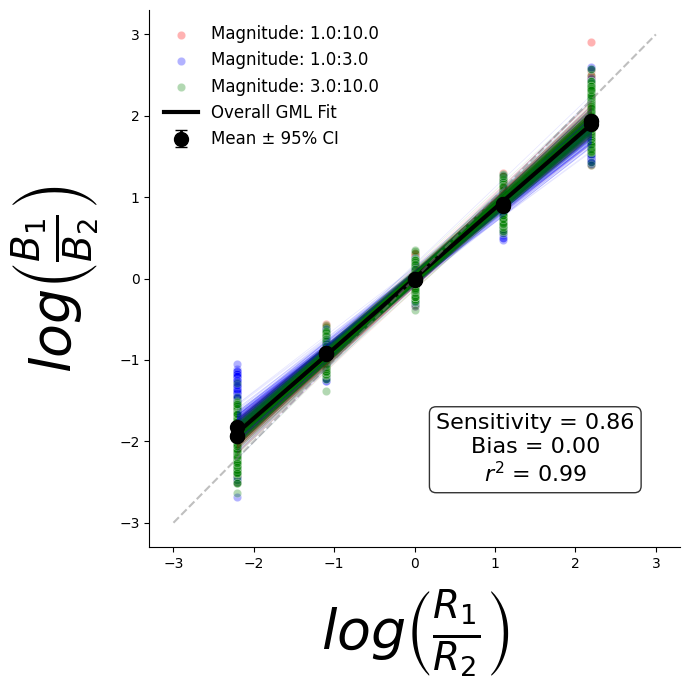

Individual AO fits summary:
Number of AOs with valid fits: 1200
Mean sensitivity across AOs: 0.860 ± 0.040
Mean bias across AOs: 0.005 ± 0.046
Mean R² across AOs: 0.989 ± 0.007


In [52]:
# Prep data
results_concurrent_vi_df['response_ratio'] = results_concurrent_vi_df['choice2_avg'] / results_concurrent_vi_df['choice1_avg']
results_concurrent_vi_df['log_resp_ratio'] = np.log(results_concurrent_vi_df['response_ratio'])
results_concurrent_vi_df['log_reinf_ratio'] = np.log(results_concurrent_vi_df['reinforcement_ratio'])

# Create normalized magnitude labels (always smaller:larger)
def normalize_magnitude_label(row):
    if row['magnitude1'] <= row['magnitude2']:
        return f"{row['magnitude1']}:{row['magnitude2']}"
    else:
        return f"{row['magnitude2']}:{row['magnitude1']}"

results_concurrent_vi_df['magnitude_label'] = results_concurrent_vi_df.apply(normalize_magnitude_label, axis=1)

# Fit GML to each AO within each magnitude label
ao_fits = []
ao_lines = []

for (ao_id, mag_label), group in results_concurrent_vi_df.groupby(["AO_id", "magnitude_label"]):
    if group['log_reinf_ratio'].nunique() < 2:
        continue
    
    X = group[['log_reinf_ratio']]
    y = group['log_resp_ratio']
    model = LinearRegression().fit(X, y)
    
    ao_fits.append({
        'AO_id': ao_id,
        'magnitude_label': mag_label,
        'sensitivity': model.coef_[0],  # 'a' parameter
        'bias': model.intercept_,       # log(c) parameter
        'r_squared': r2_score(y, model.predict(X))
    })
    
    # Store line for plotting
    x_range = np.linspace(X.min(), X.max(), 100)
    ao_lines.append(pd.DataFrame({
        'AO_id': ao_id,
        'magnitude_label': mag_label,
        'x': x_range.squeeze(),
        'y': model.predict(pd.DataFrame({'log_reinf_ratio': x_range.squeeze()}))
    }))

# Convert to DataFrames
fit_df = pd.DataFrame(ao_fits)
ao_lines_df = pd.concat(ao_lines)

# Aggregate means across AOs per VI pair (not magnitude label) for overall fit
grouped_means = results_concurrent_vi_df.groupby(['magnitude_label', 'reinforcement_ratio']).agg(
    log_resp_ratio_mean=('log_resp_ratio', 'mean'),
    log_resp_ratio_se=('log_resp_ratio', sem),
    log_reinf_ratio=('log_reinf_ratio', 'mean')
).reset_index()

grouped_means['log_resp_ratio_ci'] = grouped_means['log_resp_ratio_se'] * t.ppf(0.975, df=len(results_concurrent_vi_df) - 1)

# Fit overall group-level GML using VI pairs (should be 5 data points)
X_group = results_concurrent_vi_df[['log_reinf_ratio']]
y_group = results_concurrent_vi_df['log_resp_ratio']

group_model = LinearRegression().fit(X_group, y_group)
group_sensitivity = group_model.coef_[0]
group_bias = group_model.intercept_
group_r2 = r2_score(y_group, group_model.predict(X_group))

x_range_group = np.linspace(X_group.min(), X_group.max(), 100)
y_pred_group = group_model.predict(pd.DataFrame({'log_reinf_ratio': x_range_group.squeeze()}))

# Plot everything
plt.figure(figsize=(7, 7))

# Define colors for different magnitude ratios
magnitude_labels = sorted(results_concurrent_vi_df['magnitude_label'].unique())
colors = ['red', 'blue', 'green']
color_map = dict(zip(magnitude_labels, colors))

# Plot individual AOs by magnitude ratio
for mag_label in magnitude_labels:
    subset = results_concurrent_vi_df[results_concurrent_vi_df['magnitude_label'] == mag_label]
    sns.scatterplot(
        x='log_reinf_ratio',
        y='log_resp_ratio',
        data=subset,
        color=color_map[mag_label],
        alpha=0.3,
        label=f'Magnitude: {mag_label}', 
    )

# Plot individual AO fits by magnitude ratio
for mag_label in magnitude_labels:
    mag_lines = ao_lines_df[ao_lines_df['magnitude_label'] == mag_label]
    for ao_id, ao_line in mag_lines.groupby('AO_id'):
        plt.plot(ao_line['x'], ao_line['y'], color=color_map[mag_label], alpha=0.1, linewidth=0.5)

# Plot mean ± 95% CI for each VI pair (overall fit)
plt.errorbar(
    x=grouped_means['log_reinf_ratio'],
    y=grouped_means['log_resp_ratio_mean'],
    yerr=grouped_means['log_resp_ratio_ci'],
    fmt='o',
    color='black',
    markersize=10,
    elinewidth=2,
    capsize=4,
    markeredgecolor='black',
    label='Mean ± 95% CI'
)

# Plot overall group fit
plt.plot(x_range_group, y_pred_group, color='black', linewidth=3, label='Overall GML Fit')

# Identity line
plt.plot([-3, 3], [-3, 3], linestyle='--', color='gray', alpha=0.5)

# Labels and annotation
plt.xlabel(r'$\mathit{log}\left(\frac{R_1}{R_2}\right)$', fontsize=40, labelpad=12)
plt.ylabel(r'$\mathit{log}\left(\frac{B_1}{B_2}\right)$', fontsize=40, labelpad=12)

plt.text(
    1.5, -2.5,
    f"Sensitivity = {group_sensitivity:.2f}\nBias = {group_bias:.2f}\n$r^2$ = {group_r2:.2f}",
    fontsize=16,
    ha='center',
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8)
)

plt.legend(frameon=False, fontsize=12, loc='upper left')
sns.despine(top=True, right=True)
plt.grid(False)
plt.tight_layout()
plt.show()

# Display summary of individual AO fits
print(f"Individual AO fits summary:")
print(f"Number of AOs with valid fits: {len(fit_df)}")
print(f"Mean sensitivity across AOs: {fit_df['sensitivity'].mean():.3f} ± {fit_df['sensitivity'].std():.3f}")
print(f"Mean bias across AOs: {fit_df['bias'].mean():.3f} ± {fit_df['bias'].std():.3f}")
print(f"Mean R² across AOs: {fit_df['r_squared'].mean():.3f} ± {fit_df['r_squared'].std():.3f}")

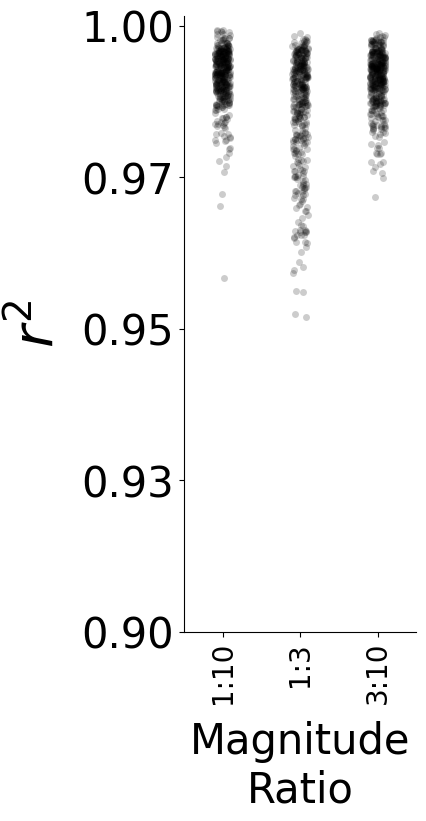

count    1200.000000
mean        0.989487
std         0.007161
min         0.951857
25%         0.987220
50%         0.991338
75%         0.994188
max         0.999320
Name: r_squared, dtype: float64

In [58]:
fig, ax = plt.subplots(figsize=(3, 8))
sns.stripplot(y=fit_df['r_squared'], x=fit_df['magnitude_label'], alpha=0.2, color='k')
sns.despine(top=True, right=True)
plt.ylabel(r"$r^2$", fontsize=40, labelpad=12)
plt.yticks(ticks=[0.9, 0.925, 0.95, 0.975, 1.0], fontsize=30)
ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
plt.xlabel("Magnitude\nRatio", fontsize=30, labelpad=12)
labels= ['1:10', '1:3', '3:10']
plt.xticks(ticks=[0, 1, 2], labels=labels, fontsize=20, rotation=90)
# plt.ylim(0.8, 1)
plt.show()
fit_df['r_squared'].describe()

In [48]:
results_concurrent_vi_df

,AO_id,pair_index,VI1,VI2,magnitude1,magnitude2,magnitude_ratio,reinforcement_ratio,arousal1_avg,arousal2_avg,coupling1_avg,coupling2_avg,choice1_avg,choice2_avg,arousal1_ci,arousal2_ci,coupling1_ci,coupling2_ci,choice1_ci,choice2_ci,activation,delta,alpha,eta,response_ratio,log_resp_ratio,log_reinf_ratio,magnitude_label
0,0,0,1,9,1,3,3.00,0.11,0.081104,5.939744e-02,0.171116,0.066006,0.818,0.182,0.006909,7.398994e-03,0.004172,0.005897,0.023955,0.023955,0.1,0.25,0.01,0.01,0.222494,-1.502856,-2.207275,1.0:3.0
1,0,1,1,9,1,10,10.00,0.11,0.027537,2.564261e-06,0.131314,0.017113,0.885,0.115,0.000214,3.194238e-07,0.000606,0.000283,0.019807,0.019807,0.1,0.25,0.01,0.01,0.129944,-2.040656,-2.207275,1.0:10.0
2,0,2,1,9,3,10,3.33,0.11,0.069067,9.997712e-04,0.132980,0.022532,0.849,0.151,0.000889,1.245679e-04,0.000763,0.000378,0.022230,0.022230,0.1,0.25,0.01,0.01,0.177856,-1.726779,-2.207275,3.0:10.0
3,0,3,1,9,3,1,0.33,0.11,0.070279,2.289463e-07,0.123956,0.022595,0.843,0.157,0.000574,2.851928e-08,0.000619,0.000290,0.022587,0.022587,0.1,0.25,0.01,0.01,0.186240,-1.680721,-2.207275,1.0:3.0
4,0,4,1,9,10,1,0.10,0.11,0.240654,9.883896e-12,0.133707,0.018728,0.872,0.128,0.004019,1.231213e-12,0.000652,0.000297,0.020742,0.020742,0.1,0.25,0.01,0.01,0.146789,-1.918759,-2.207275,1.0:10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,399,25,9,1,1,10,10.00,9.00,0.000000,3.824000e+00,0.026954,0.131271,0.158,0.842,0.000000,4.236460e-01,0.000915,0.001595,0.022645,0.022645,1.6,2.00,1.00,1.00,5.329114,1.673185,2.197225,1.0:10.0
11996,399,26,9,1,3,10,3.33,9.00,0.000000,3.808000e+00,0.023257,0.130311,0.162,0.838,0.000000,4.230364e-01,0.000709,0.001578,0.022876,0.022876,1.6,2.00,1.00,1.00,5.172840,1.643422,2.197225,3.0:10.0
11997,399,27,9,1,3,1,0.33,9.00,0.000000,4.560000e-01,0.016649,0.132508,0.104,0.896,0.000000,4.484224e-02,0.000727,0.001600,0.018952,0.018952,1.6,2.00,1.00,1.00,8.615385,2.153550,2.197225,1.0:3.0
11998,399,28,9,1,10,1,0.10,9.00,0.000000,3.968000e-01,0.016908,0.125743,0.121,0.879,0.000000,4.289894e-02,0.000776,0.001703,0.020248,0.020248,1.6,2.00,1.00,1.00,7.264463,1.982994,2.197225,1.0:10.0


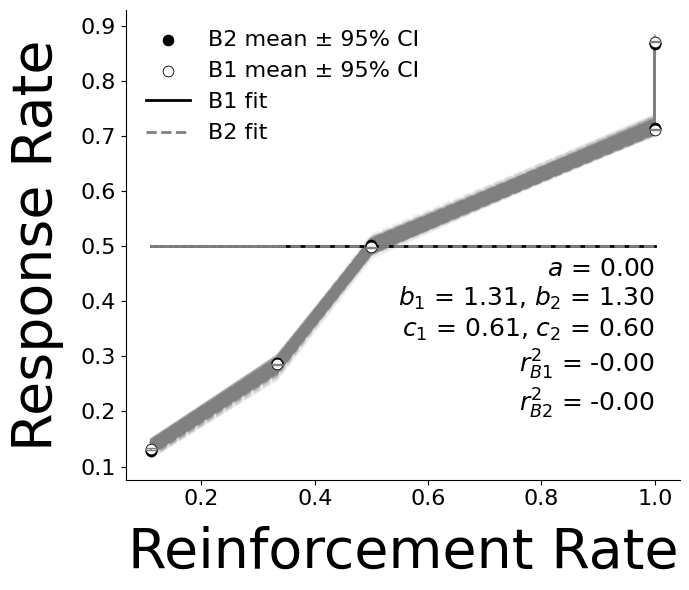

In [69]:
# Define McDowell concurrent schedule equations
def B1_eq(r1, r2, a, b1, c1, c2):
    return (b1 * (r1 ** a)) / (r1 ** a + (c1 / c2) * (r2 ** a) + c1)

def B2_eq(r1, r2, a, b2, c1, c2):
    return (b2 * (r2 ** a)) / ((c2 / c1) * (r1 ** a) + (r2 ** a) + c2)

# Joint residual function for least squares
def joint_residuals(params, r1, r2, B1_obs, B2_obs):
    a, b1, b2, c1, c2 = params
    B1_pred = B1_eq(r1, r2, a, b1, c1, c2)
    B2_pred = B2_eq(r1, r2, a, b2, c1, c2)
    return np.concatenate([(B1_pred - B1_obs), (B2_pred - B2_obs)])

# Prepare data
results_df = results_concurrent_vi_df.copy()
results_df['r1'] = 1 / results_df['VI1']
results_df['r2'] = 1 / results_df['VI2']

# Fit per AO
fit_results = []
ao_fits = []

for ao_id, group in results_df.groupby("AO_id"):
    if group.shape[0] < 5:
        continue
    try:
        x0 = [1.0, 1.0, 1.0, 0.1, 0.1]
        res = least_squares(
            joint_residuals,
            x0=x0,
            bounds=(0, np.inf),
            args=(group['r1'].values, group['r2'].values, group['choice1_avg'].values, group['choice2_avg'].values)
        )
        a, b1, b2, c1, c2 = res.x

        # Compute predictions and R²
        B1_pred = B1_eq(group['r1'], group['r2'], a, b1, c1, c2)
        B2_pred = B2_eq(group['r1'], group['r2'], a, b2, c1, c2)
        r2_B1 = r2_score(group['choice1_avg'], B1_pred)
        r2_B2 = r2_score(group['choice2_avg'], B2_pred)

        fit_results.append({
            'AO_id': ao_id,
            'a': a, 'b1': b1, 'b2': b2, 'c1': c1, 'c2': c2,
            'r2_B1': r2_B1, 'r2_B2': r2_B2
        })

        ao_fits.append({
            'AO_id': ao_id,
            'r1': group['r1'].values,
            'r2': group['r2'].values,
            'B1_pred': B1_pred,
            'B2_pred': B2_pred
        })
    except:
        continue

fit_df = pd.DataFrame(fit_results)

# Group means and CI
grouped = results_df.groupby(['VI1', 'VI2']).agg({
    'r1': 'mean',
    'r2': 'mean',
    'choice1_avg': ['mean', sem],
    'choice2_avg': ['mean', sem]
}).reset_index()

grouped.columns = ['VI1', 'VI2', 'r1', 'r2', 'B1_mean', 'B1_se', 'B2_mean', 'B2_se']
grouped['B1_ci'] = grouped['B1_se'] * t.ppf(0.975, df=len(results_df) - 1)
grouped['B2_ci'] = grouped['B2_se'] * t.ppf(0.975, df=len(results_df) - 1)

# Fit model to group means
x0 = [1.0, 1.0, 1.0, 0.1, 0.1]
res = least_squares(
    joint_residuals,
    x0=x0,
    bounds=(0, np.inf),
    args=(grouped['r1'].values, grouped['r2'].values, grouped['B2_mean'].values, grouped['B1_mean'].values)
)
a, b1, b2, c1, c2 = res.x

grouped['B1_pred'] = B1_eq(grouped['r1'], grouped['r2'], a, b1, c1, c2)
grouped['B2_pred'] = B2_eq(grouped['r1'], grouped['r2'], a, b2, c1, c2)

r2_B1 = r2_score(grouped['B1_mean'], grouped['B1_pred'])
r2_B2 = r2_score(grouped['B2_mean'], grouped['B2_pred'])

# Plot
plt.figure(figsize=(7, 6))

# All AO lines in gray
for fit in ao_fits:
    plt.plot(fit['r1'], fit['B1_pred'], color='gray', alpha=0.1, zorder=1)
    plt.plot(fit['r2'], fit['B2_pred'], color='gray', alpha=0.1, linestyle='--', zorder=1)

# Mean data points with CI
sns.scatterplot(x=grouped['r1'], y=grouped['B1_mean'], color='black', edgecolor='black', s=60,
                label='B2 mean ± 95% CI', zorder=10)
plt.errorbar(grouped['r1'], grouped['B1_mean'], yerr=grouped['B2_ci'], fmt='none',
             ecolor='black', capsize=4, zorder=10)

sns.scatterplot(x=grouped['r2'], y=grouped['B2_mean'], color='white', edgecolor='black', s=60,
                label='B1 mean ± 95% CI', zorder=10)
plt.errorbar(grouped['r2'], grouped['B2_mean'], yerr=grouped['B1_ci'], fmt='none',
             ecolor='gray', capsize=4, zorder=10)

# Group fits in bold
plt.plot(grouped['r1'], grouped['B1_pred'], color='black', linewidth=2,
         label='B1 fit', zorder=9)
plt.plot(grouped['r2'], grouped['B2_pred'], color='gray', linewidth=2, linestyle='--',
         label='B2 fit', zorder=9)

# Annotation
plt.text(
    1, 0.2,
    f"$a$ = {a:.2f}\n"
    f"$b_1$ = {b1:.2f}, $b_2$ = {b2:.2f}\n"
    f"$c_1$ = {c1:.2f}, $c_2$ = {c2:.2f}\n"
    f"$r^2_{{B1}}$ = {r2_B1:.2f}\n"
    f"$r^2_{{B2}}$ = {r2_B2:.2f}",
    fontsize=18,
    ha='right'
)

plt.xlabel('Reinforcement Rate', fontsize=40, labelpad=12)
plt.ylabel('Response Rate', fontsize=40, labelpad=12)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.legend(frameon=False, fontsize=16)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()
